# Defining Classes

In [143]:
doremi_dir = "/kaggle/input/doremi-raw-dataset/DoReMi_v1/"

In [144]:
class Staff:
    def __init__(self, center: float, upper_bound: int, lower_bound: int, unit_size: float, track: int):
        self.center = center
        self.upper_bound = upper_bound
        self.lower_bound = lower_bound
        self.unit_size = unit_size
        self.track = track

    def __repr__(self):
        return (
            "Staff {\n"
            f"    Center: {self.center:.1f}\n"
            f"    Upper bound: {self.upper_bound}\n"
            f"    Lower bound: {self.lower_bound}\n"
            f"    Unit size: {self.unit_size:.1f}\n"
            f"    Track: {self.track}\n"
            "}"
        )
        
class Note:
    def __init__(self, class_name: str, top: int, left: int, width: int, height: int, img_name: str):
        self.class_name = class_name
        self.top = top
        self.left = left
        self.width = width
        self.height = height
        self.image = img_name
    def gather_coordinates(self):
        return [self.top, self.left, self.width, self.height]
    def create_box(self):
        return [(self.left, self.top), (self.left + self.width, self.top + self.height)]

# Preprocessing Images

## Sample Image

<?xml version="1.0" ?><Page pageIndex="0">
	<Nodes>
		<Node>
			<Id>230</Id>
			<ClassName>accidentalSharp</ClassName>
			<Top>1049</Top>
			<Left>539</Left>
			<Width>21</Width>
			<Height>59</Height


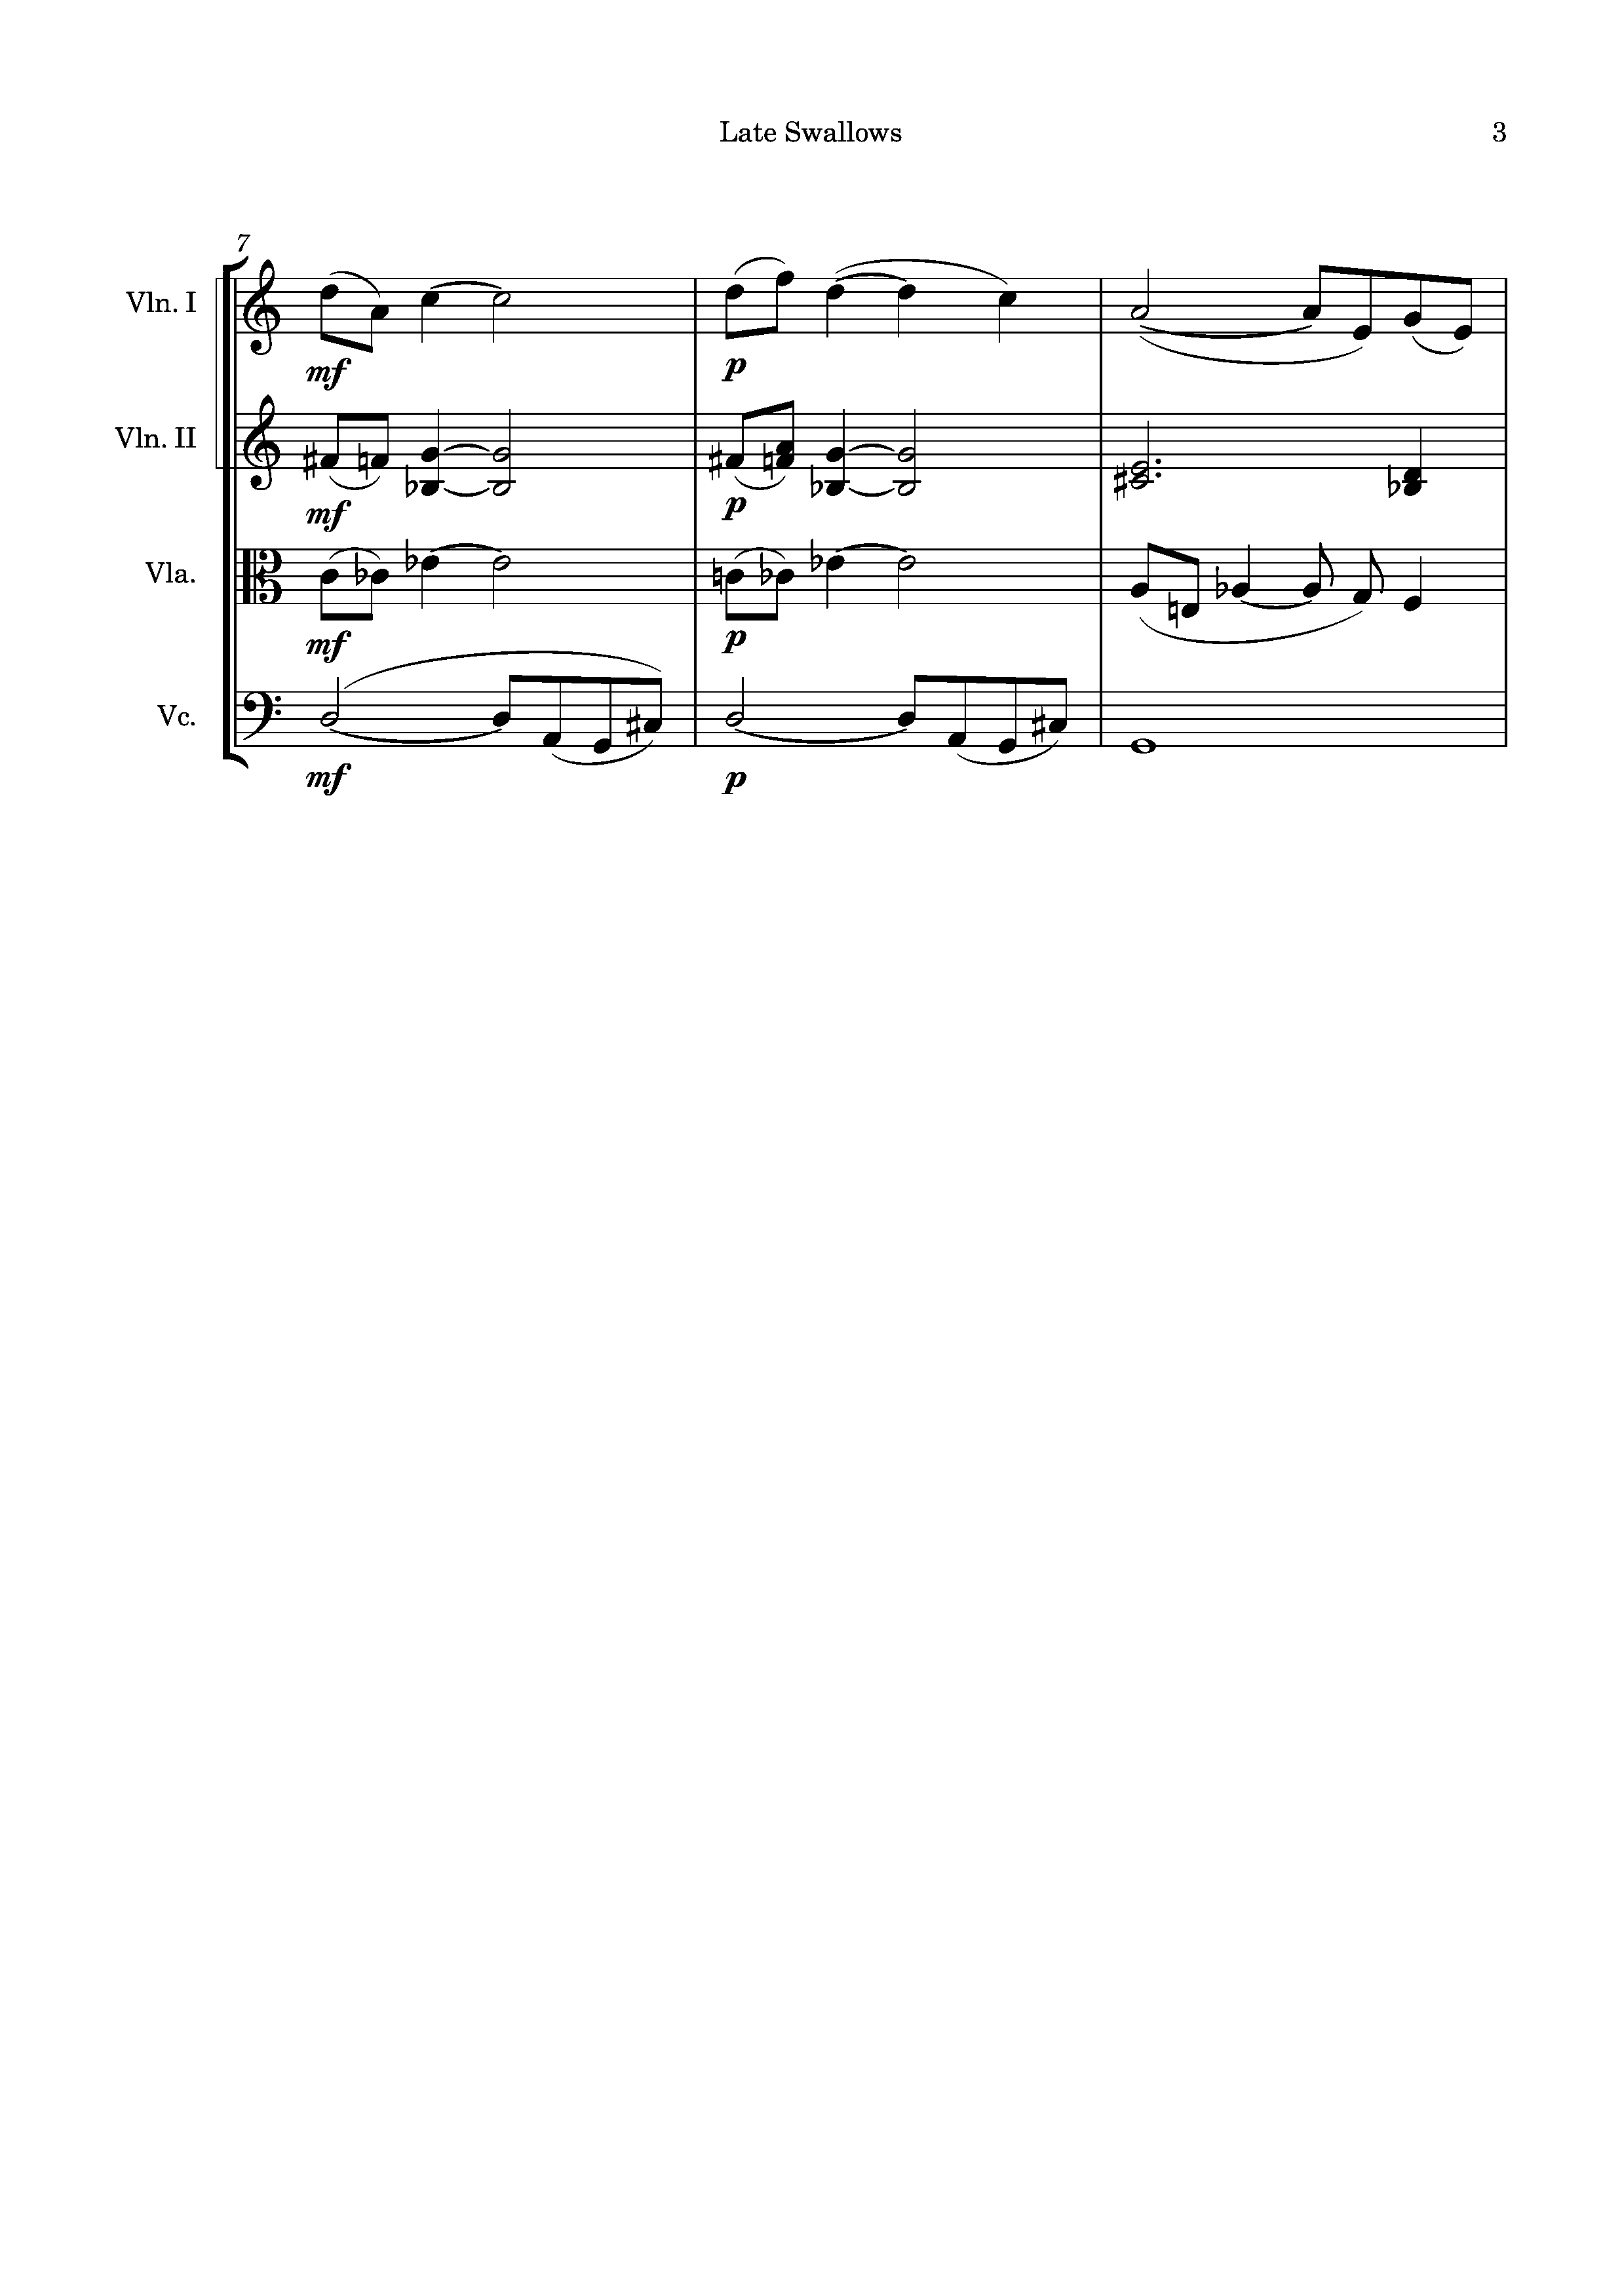

In [145]:
from PIL import Image

img_path = doremi_dir + 'Images/Delius - String Quartet mvt III-003.png'
image = Image.open(img_path)
file_path = doremi_dir + 'Parsed_by_page_omr_xml/Parsed_Alkan - Posement-layout-0-muscima_Page_1.xml'
with open(file_path, 'r') as file:
    content = file.read(200)
    print(content)
image

## Preprocessing Stafflines

In [146]:
import re
import pprint
import os

def natural_key(string):
    return [int(s) if s.isdigit() else s.lower() for s in re.split('(\d+)', string)]

# Sorts Images and Parsed_by_page_omr_xml directories
image_list = os.listdir(doremi_dir + "Images")
omr_xml_list =  os.listdir(doremi_dir + "Parsed_by_page_omr_xml")

image_list.sort(key=natural_key)
omr_xml_list.sort(key=natural_key)

# Matches each .png file to their respective omr_xml file
image_to_omr = {img: omr for img, omr in zip(image_list, omr_xml_list)}

def extract_staffs_from_image(cropped_image, padding_multiplier=4.5):
    image_gray = cropped_image.convert("L")
    image_np = np.array(image_gray)
    _, binary = cv2.threshold(image_np, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    horizontal_projection = np.sum(binary, axis=1)
    peaks, _ = find_peaks(horizontal_projection, height=np.max(horizontal_projection) * 0.5, distance=5)

    grouped_staffs = []
    for i in range(0, len(peaks) - 4, 5):
        group = peaks[i:i+5]
        grouped_staffs.append(group)

    staff_objects = []
    for i, group in enumerate(grouped_staffs):
        y_center = float(np.mean(group))
        unit_size = float(np.mean(np.diff(group)))
        padding = int(unit_size * padding_multiplier)

        y_min = int(np.min(group) - padding)
        y_max = int(np.max(group) + padding)
        track = i % 2 + 1

        staff = Staff(
            center=y_center,
            upper_bound=y_min,
            lower_bound=y_max,
            unit_size=unit_size,
            track=track
        )
        staff_objects.append(staff)

    return staff_objects

In [147]:
from PIL import Image
import os
import numpy as np
import cv2 
from scipy.signal import find_peaks

images = []
staff_data_per_image = {}

selected_files = [
    "Delius - String Quartet mvt III",
    "Schumann - String Quartet 1 mvt 3",
    "Webern - Variations Op 27 III"]

for image_name in image_list:
    if not any(image_name.startswith(prefix) for prefix in selected_files):
        continue

    image_path = os.path.join(doremi_dir, "Images", image_name)
    try:
        cropped_image = Image.open(image_path)
        staff_objects = extract_staffs_from_image(cropped_image)

        images.append(image_name)
        staff_data_per_image[image_name] = staff_objects 

        if len(images) == 200:
            break
    except Exception as e:
        print(f"Skipping {image_name} due to error: {e}")
        continue

# Confirm results
print(f"\nFound {len(images)} images.\n") 
print(images)


Found 90 images.

['Delius - String Quartet mvt III-001.png', 'Delius - String Quartet mvt III-002.png', 'Delius - String Quartet mvt III-003.png', 'Delius - String Quartet mvt III-004.png', 'Delius - String Quartet mvt III-005.png', 'Delius - String Quartet mvt III-006.png', 'Delius - String Quartet mvt III-007.png', 'Delius - String Quartet mvt III-008.png', 'Delius - String Quartet mvt III-009.png', 'Delius - String Quartet mvt III-010.png', 'Delius - String Quartet mvt III-011.png', 'Delius - String Quartet mvt III-012.png', 'Delius - String Quartet mvt III-013.png', 'Delius - String Quartet mvt III-014.png', 'Delius - String Quartet mvt III-015.png', 'Delius - String Quartet mvt III-016.png', 'Delius - String Quartet mvt III-017.png', 'Delius - String Quartet mvt III-018.png', 'Delius - String Quartet mvt III-020.png', 'Delius - String Quartet mvt III-021.png', 'Delius - String Quartet mvt III-022.png', 'Delius - String Quartet mvt III-023.png', 'Delius - String Quartet mvt III-0

In [148]:
max_height = 0
max_image_name = None
max_upper = None
max_lower = None

IMG_TO_STAFF = {}

for image_name in images:
    image_path = os.path.join(doremi_dir + "Images", image_name)
    img = Image.open(image_path)

    staff_objects = extract_staffs_from_image(img)
    n = len(staff_objects)
    if max_upper == None or staff_objects[0].upper_bound < max_upper:
        max_upper = staff_objects[0].upper_bound
        
    if max_lower == None or staff_objects[n - 1].lower_bound > max_lower:
        max_lower = staff_objects[n - 1].lower_bound

    IMG_TO_STAFF[image_name] = staff_objects

print(f"Upper bound: {max_upper}")
print(f"Lower bound: {max_lower}")

Upper bound: 312
Lower bound: 1570


Staff {
    Center: 465.6
    Upper bound: 352
    Lower bound: 579
    Unit size: 20.8
    Track: 1
}
Staff {
    Center: 672.6
    Upper bound: 559
    Lower bound: 786
    Unit size: 20.8
    Track: 2
}
Staff {
    Center: 879.2
    Upper bound: 767
    Lower bound: 991
    Unit size: 20.5
    Track: 1
}
Staff {
    Center: 1096.6
    Upper bound: 983
    Lower bound: 1210
    Unit size: 20.8
    Track: 2
}


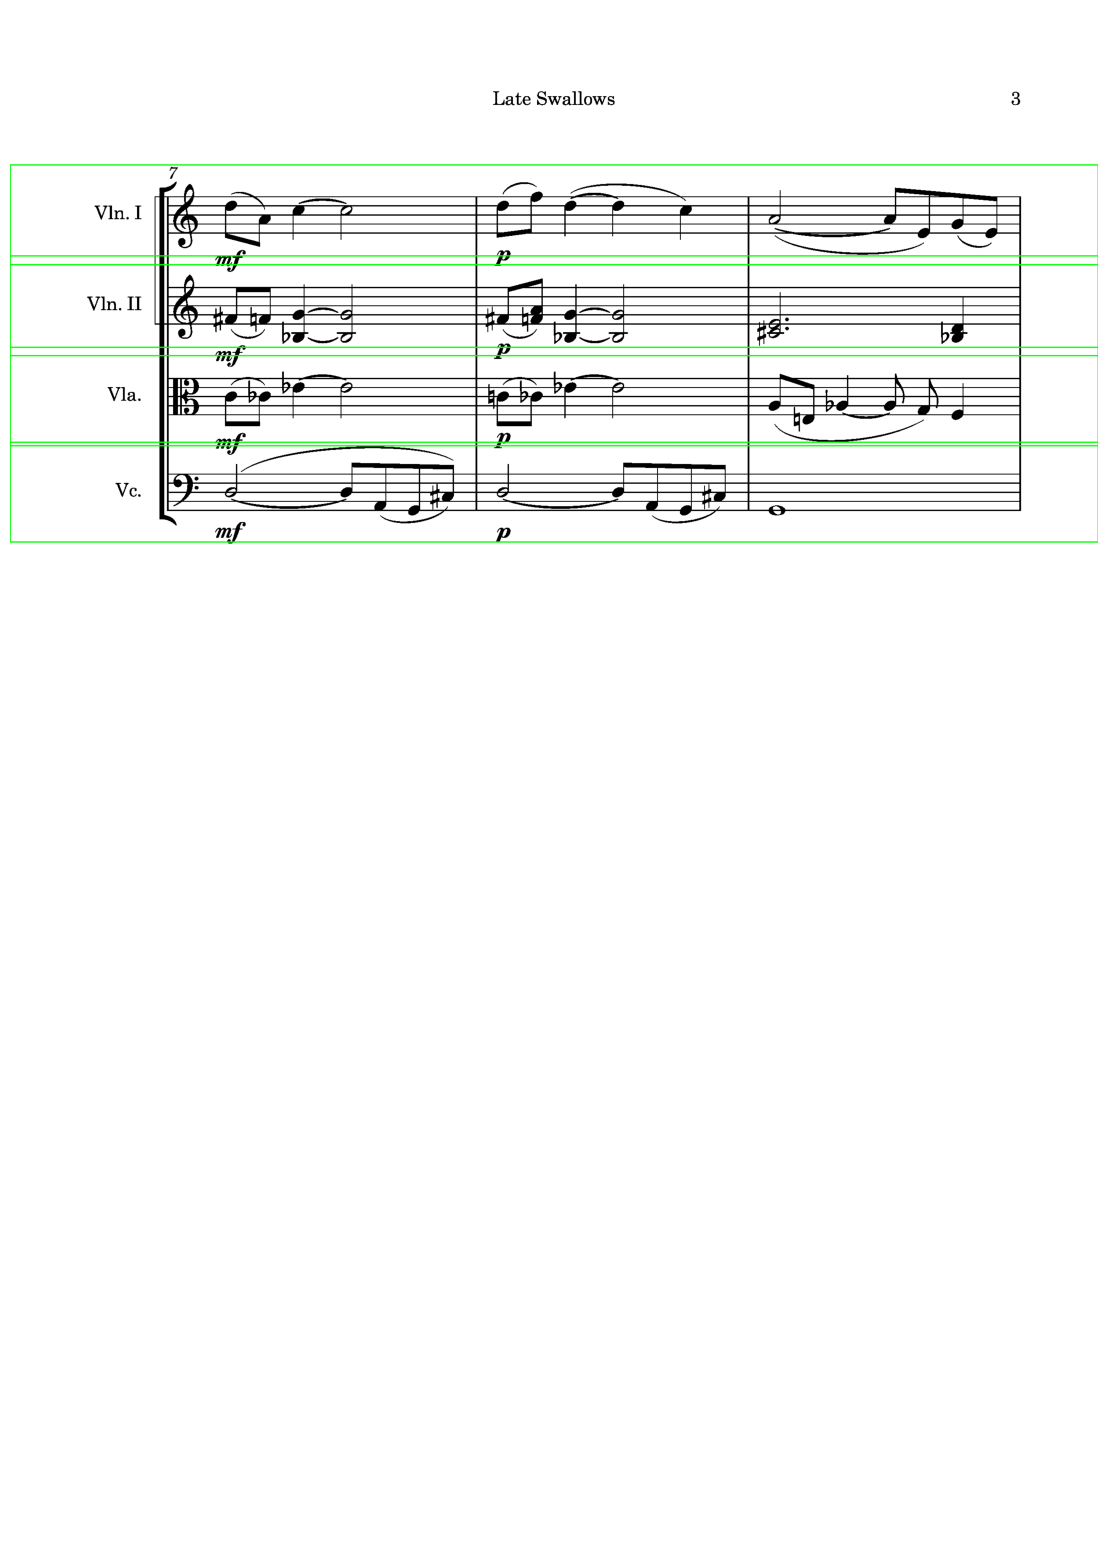

In [149]:
import cv2
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt

image_gray = image.convert("L")
image_np = np.array(image_gray)

_, binary = cv2.threshold(image_np, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

horizontal_projection = np.sum(binary, axis=1)

peaks, _ = find_peaks(horizontal_projection, height=np.max(horizontal_projection) * 0.5, distance=5)

grouped_staffs = []
for i in range(0, len(peaks) - 4, 5):
    group = peaks[i:i+5]
    grouped_staffs.append(group)

image_color = np.stack([image_np]*3, axis=-1)

staff_bounds = []
staff_bounds = []
staff_objects = []

for i, group in enumerate(grouped_staffs):
    y_center = float(np.mean(group))
    unit_size = float(np.mean(np.diff(group)))
    padding = int(unit_size * 3.5)

    y_min = int(np.min(group) - padding)
    y_max = int(np.max(group) + padding)
    track = i % 2 + 1

    staff = Staff(
        center=y_center,
        upper_bound=y_min,
        lower_bound=y_max,
        unit_size=unit_size,
        track=track
    )
    staff_objects.append(staff)
    staff_bounds.append((y_min, y_max))

    cv2.rectangle(image_color, (0, y_min), (image_np.shape[1], y_max), (0, 255, 0), 2)
    print(staff)


plt.figure(figsize=(20, 20))
plt.imshow(image_color)
plt.axis("off")
plt.show()

## Preprocessing Notes

In [150]:
import xml.etree.ElementTree as ET

IMAGE_TO_NOTES = {}
for key in images:
# Parse the XML file
    xml_path = os.path.join(doremi_dir, "Parsed_by_page_omr_xml", image_to_omr[key])
    tree = ET.parse(xml_path) 
    root = tree.getroot()
# Define target classnames
    target_classes = {'noteheadBlack', 'noteheadHalf', 'noteheadWhole'}

# Collect matching nodes
    matching_nodes = []

# Loop through all <Node> elements
    for node in root.findall('.//Node'):
        class_name = node.find('ClassName')
        if class_name is not None and class_name.text in target_classes:
            matching_nodes.append(node)

# Print results
    final_notes = []
    for match in matching_nodes:
        note = Note(match.find("ClassName").text, 
                    int(match.find("Top").text), 
                    int(match.find("Left").text), 
                    int(match.find("Width").text), 
                    int(match.find("Height").text), 
                    key
                   )
        final_notes.append(note)
        # print(note.image)
    IMAGE_TO_NOTES[key] = final_notes

### Cropping Stafflines

In [151]:
CROPPED_NOTE_PAIRS = []
for image_name, notes in IMAGE_TO_NOTES.items():
    image_path = os.path.join(doremi_dir + "Images", image_name)
    img = Image.open(image_path)
    width = img.width
    
    # Crop image to vertical slice (top to bottom)
    cropped = img.crop((0, max_upper, width, max_lower))
    for note in notes:
        note.top -= max_upper
    CROPPED_NOTE_PAIRS.append((cropped, notes))

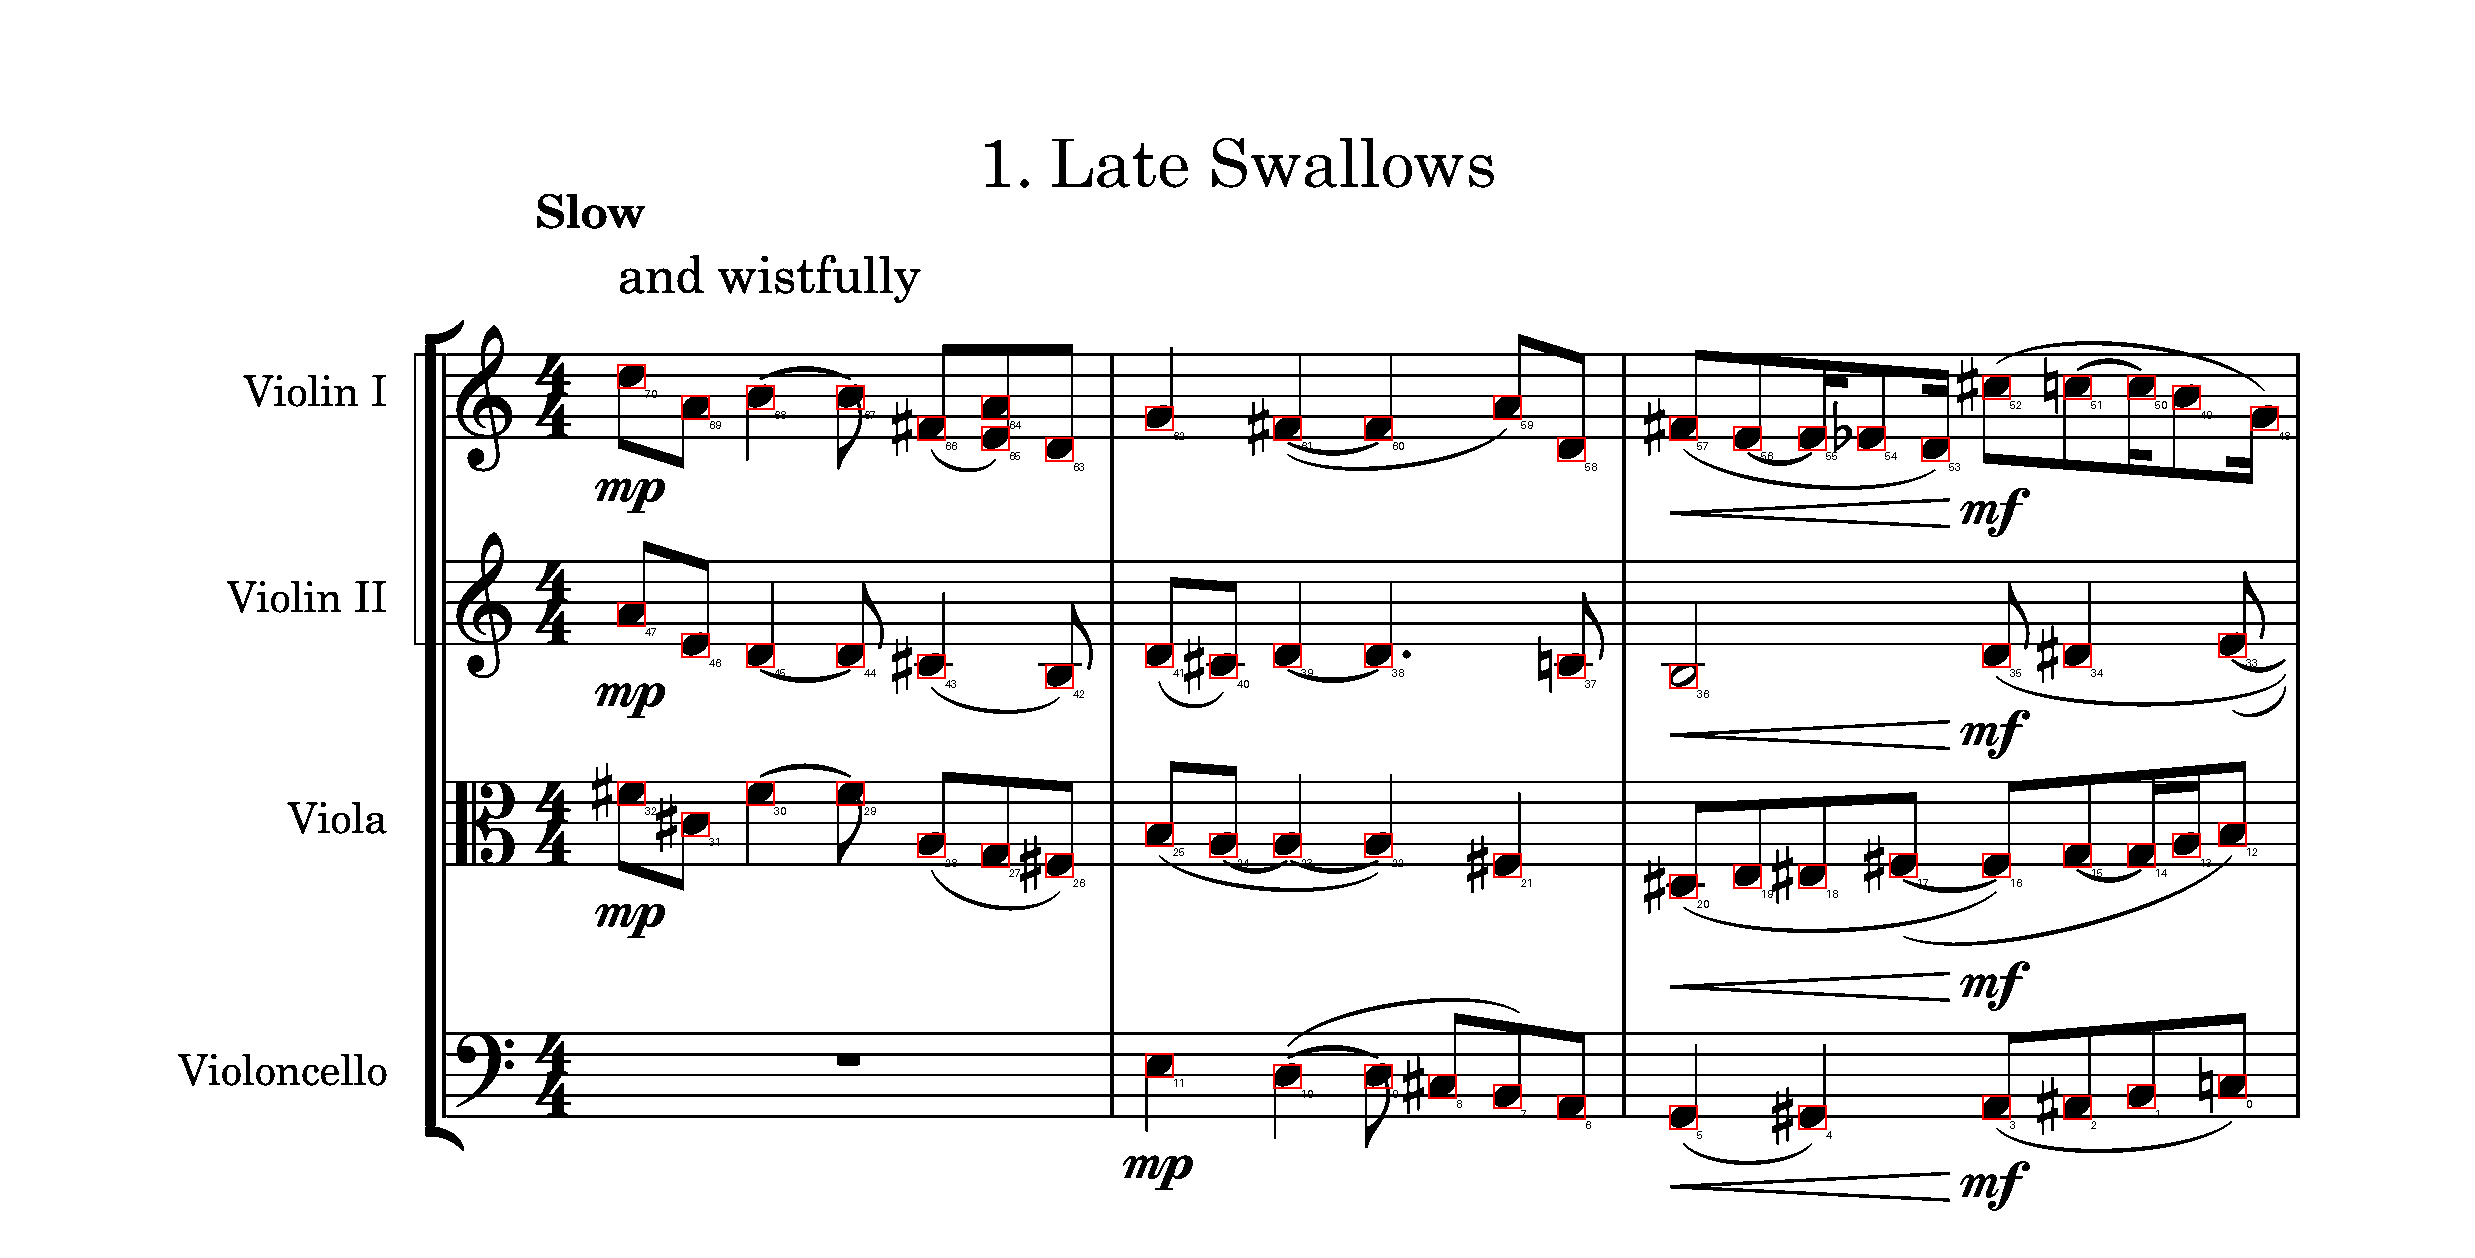

2475
1258


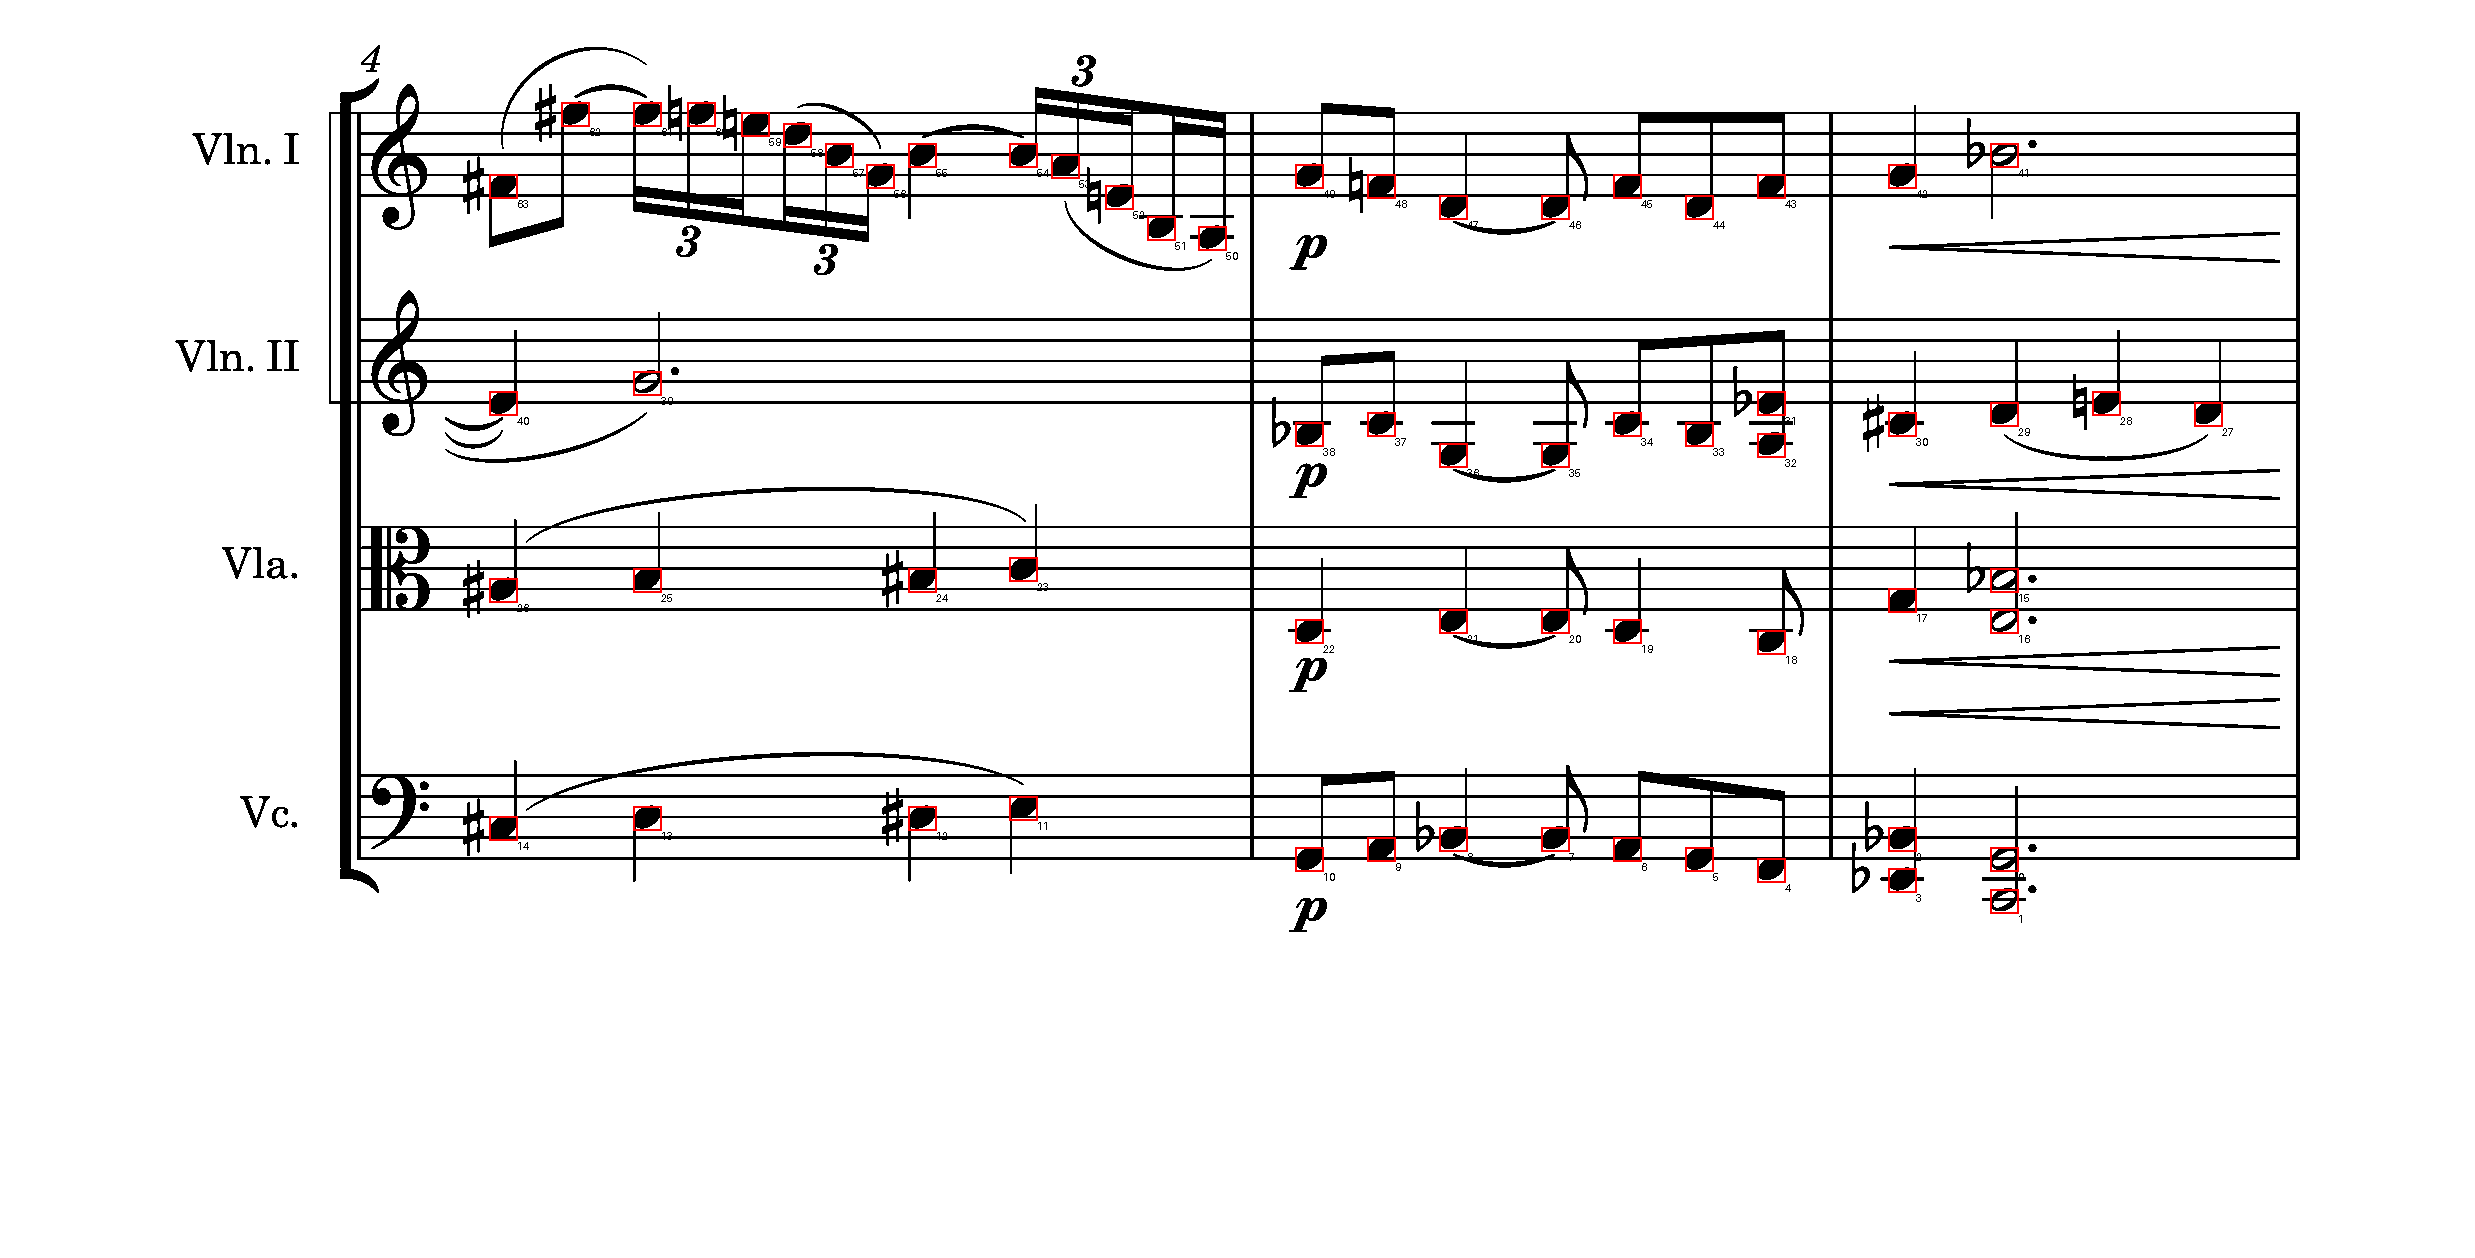

2475
1258


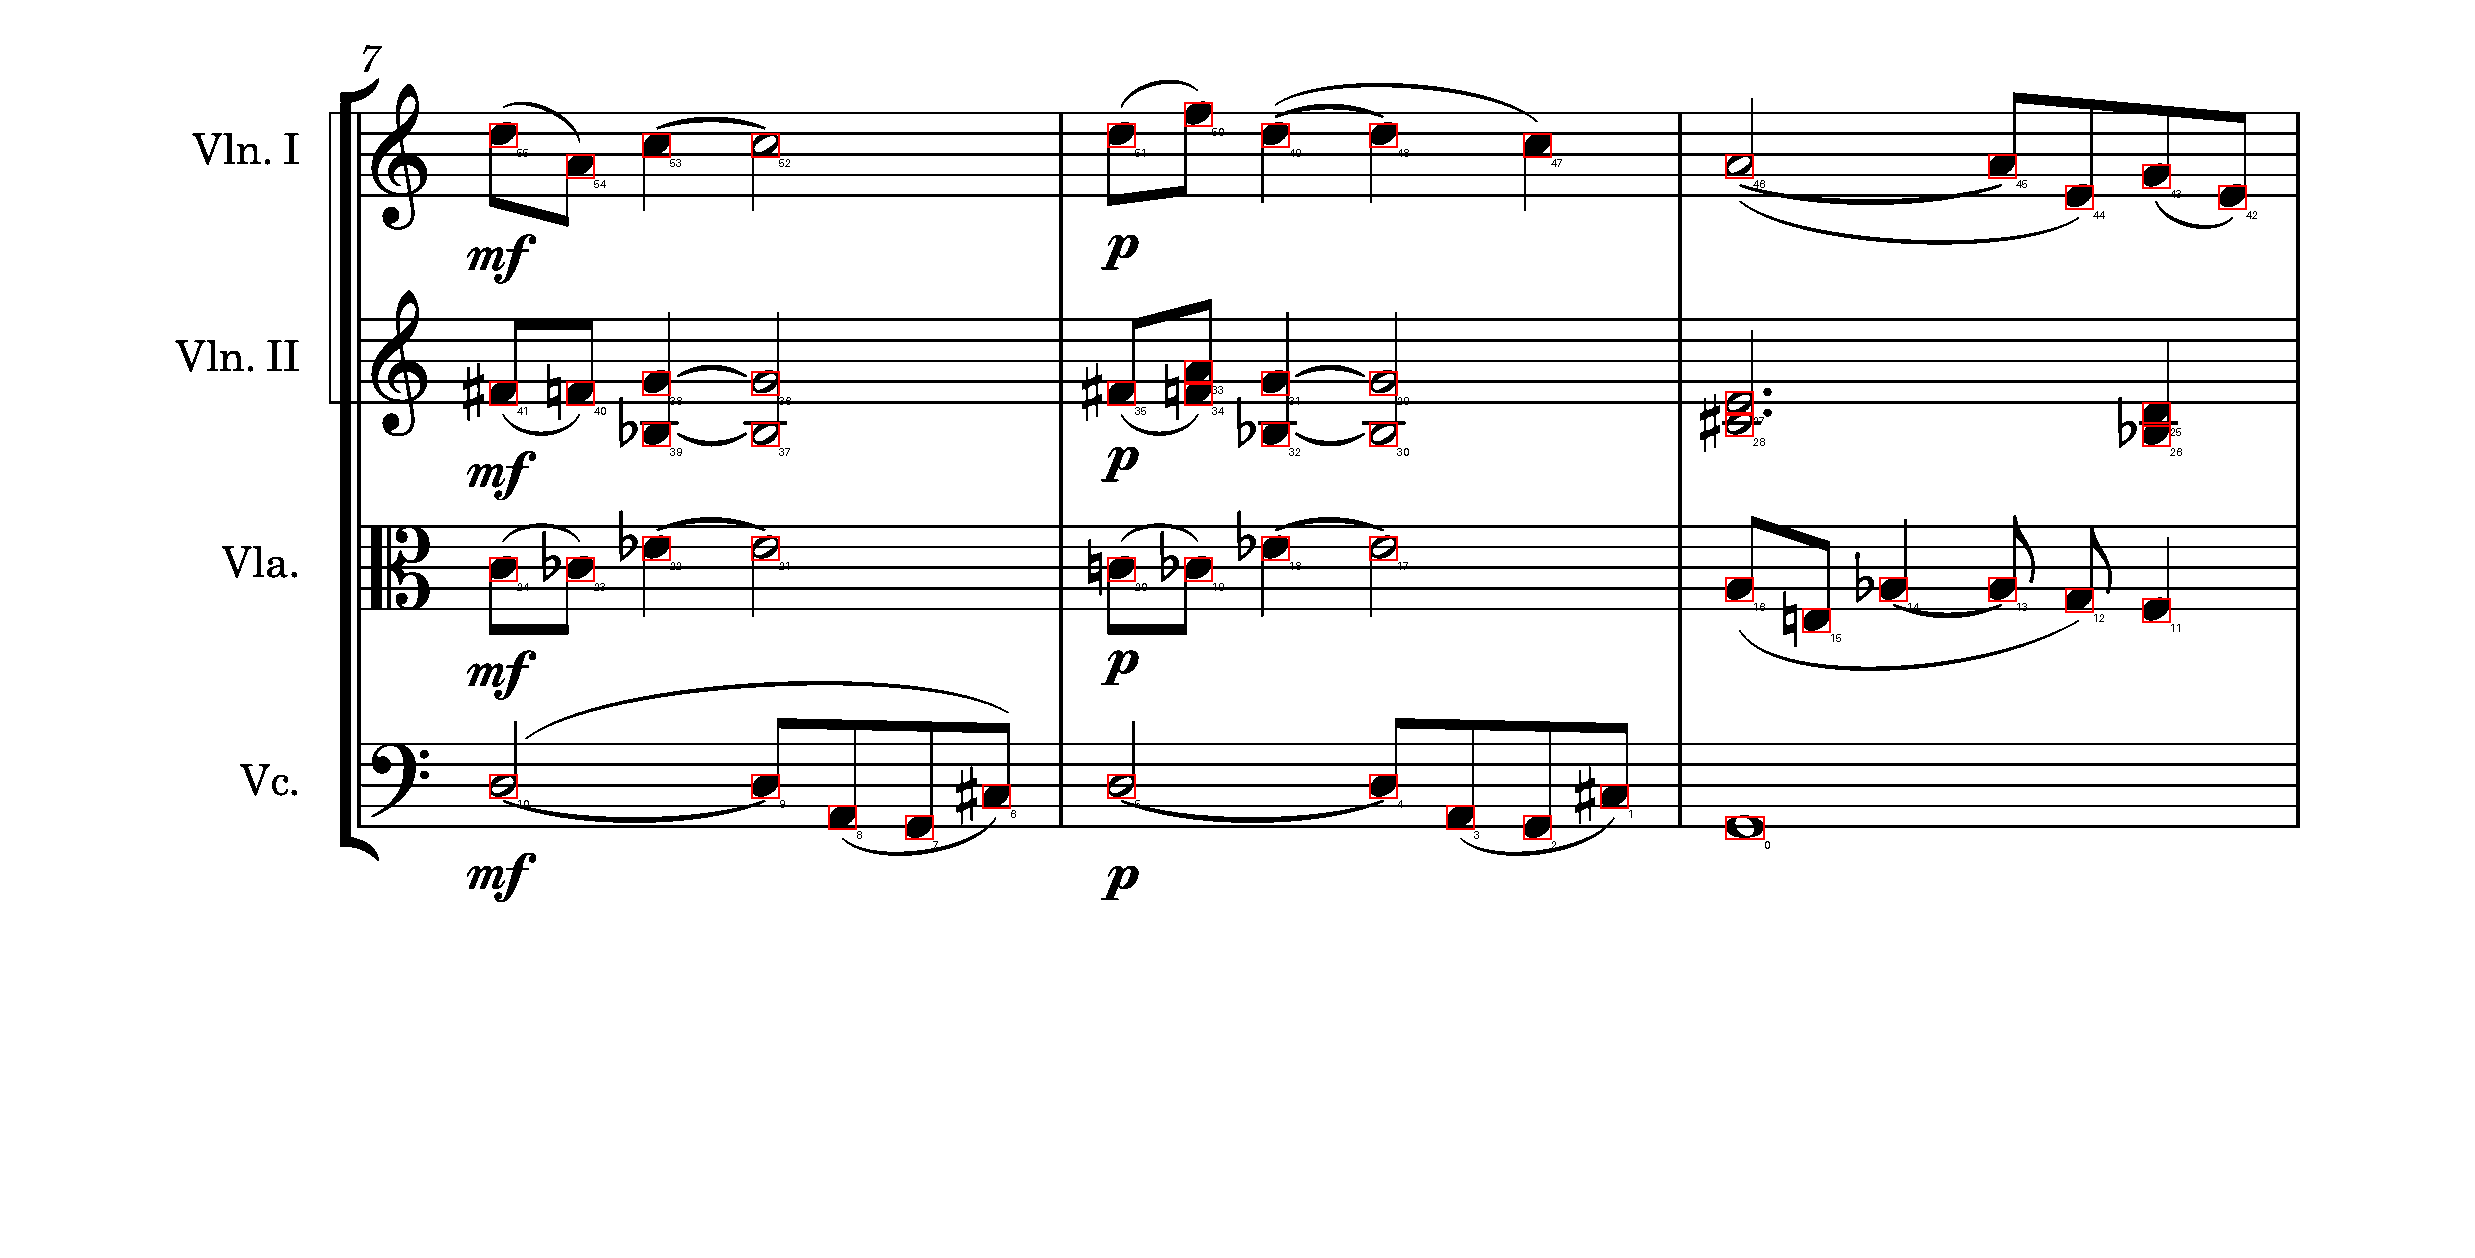

2475
1258


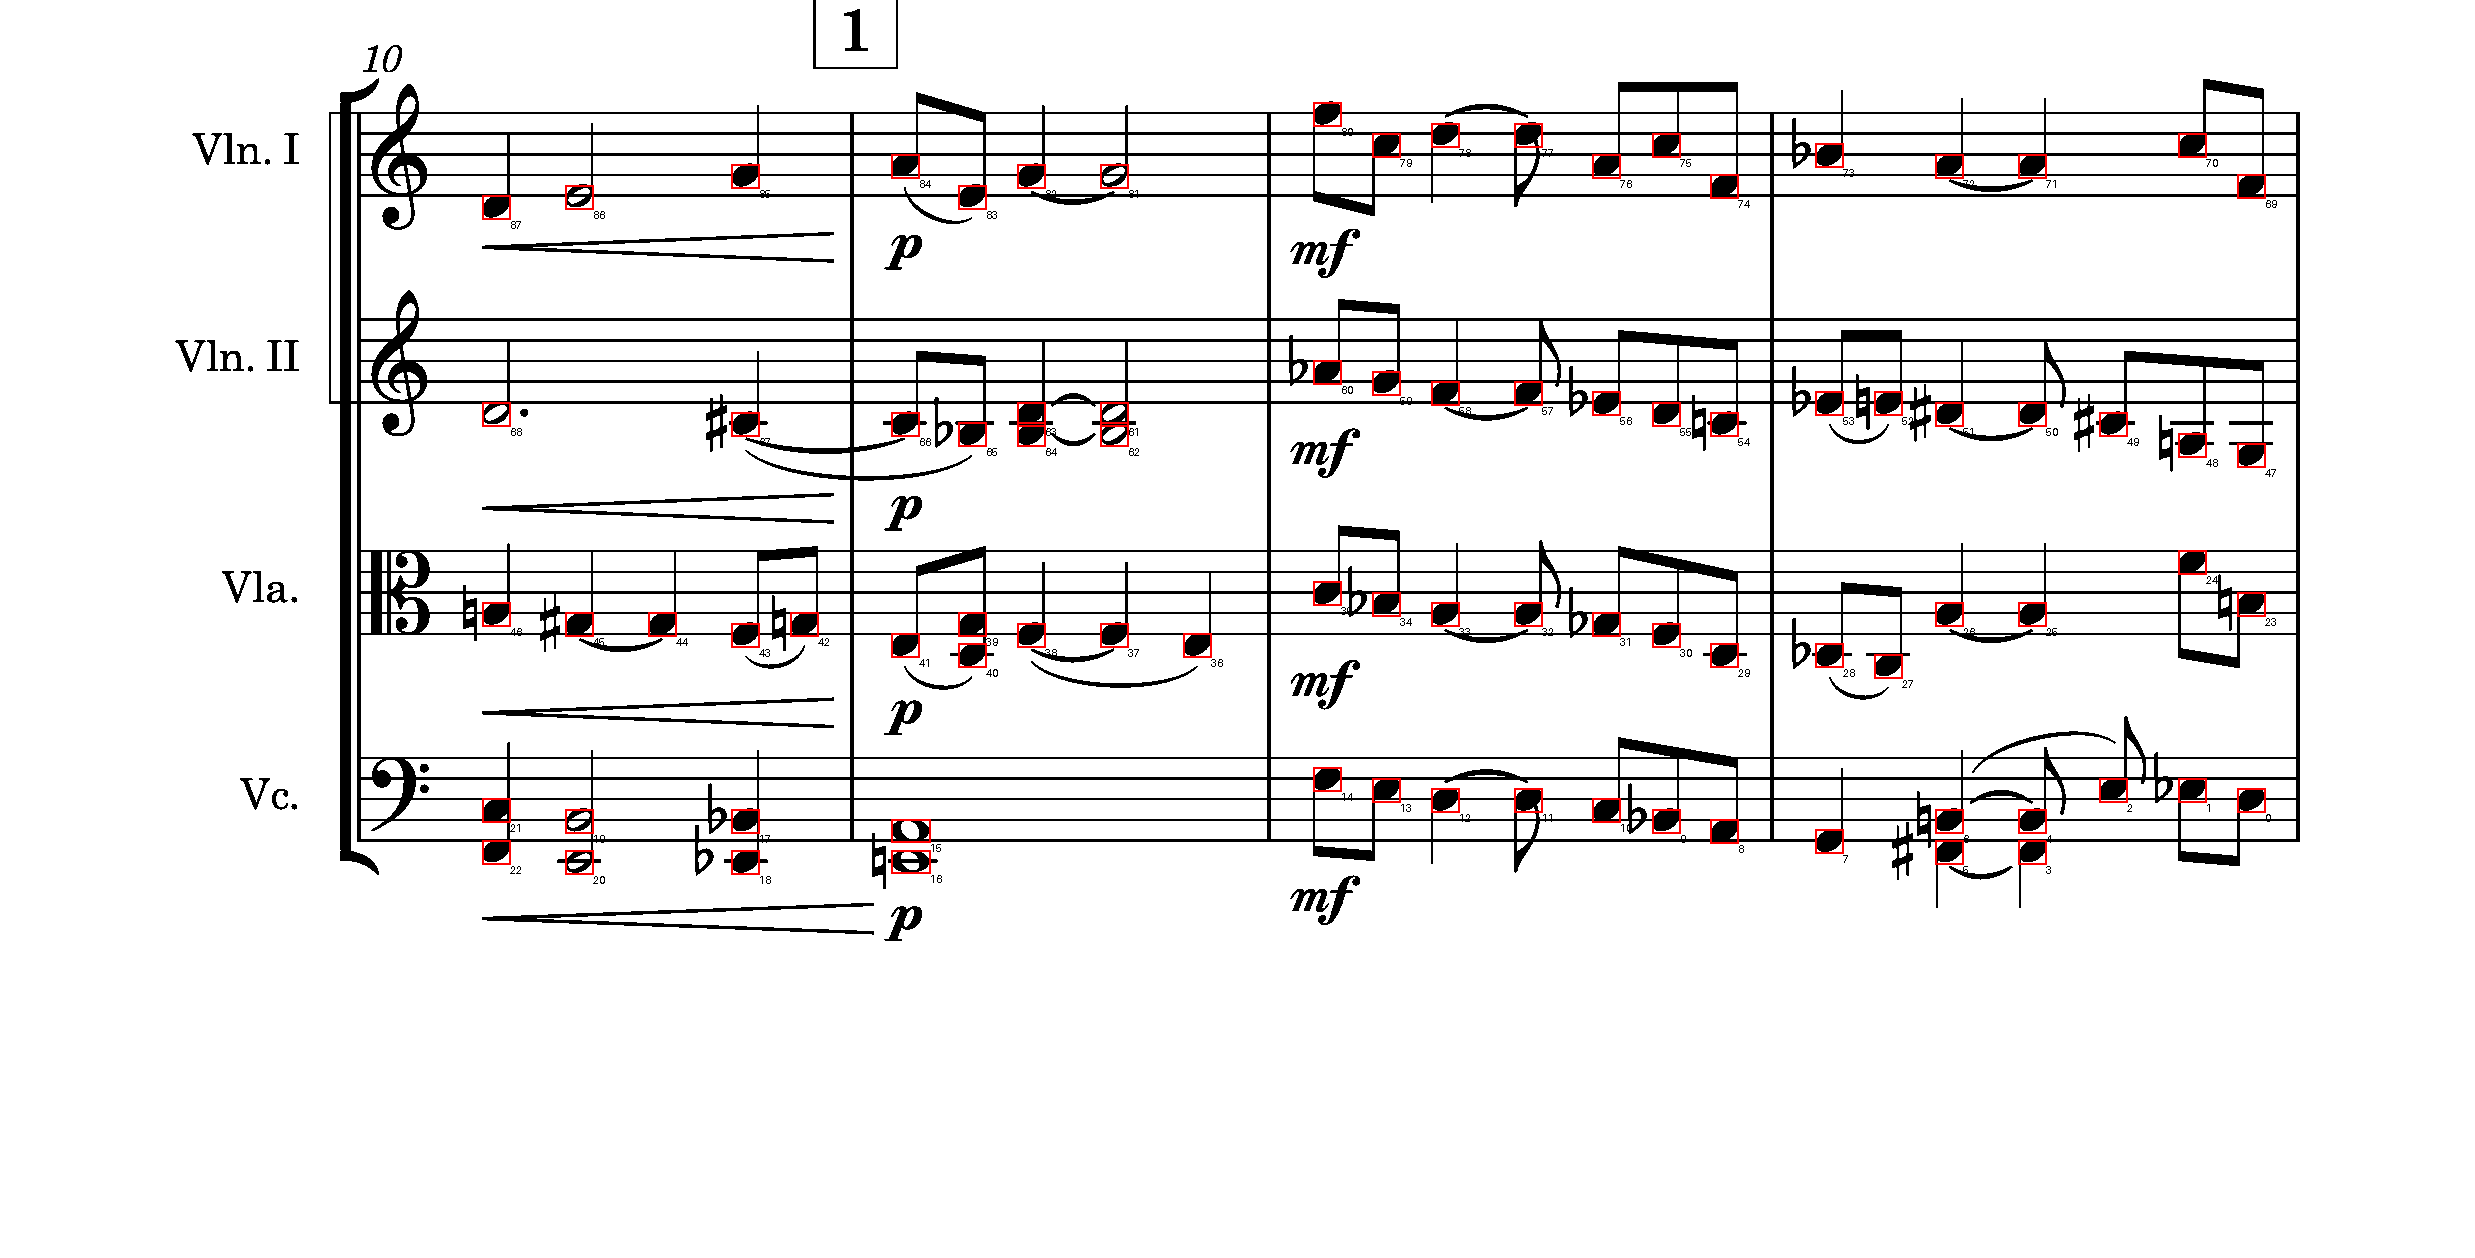

2475
1258


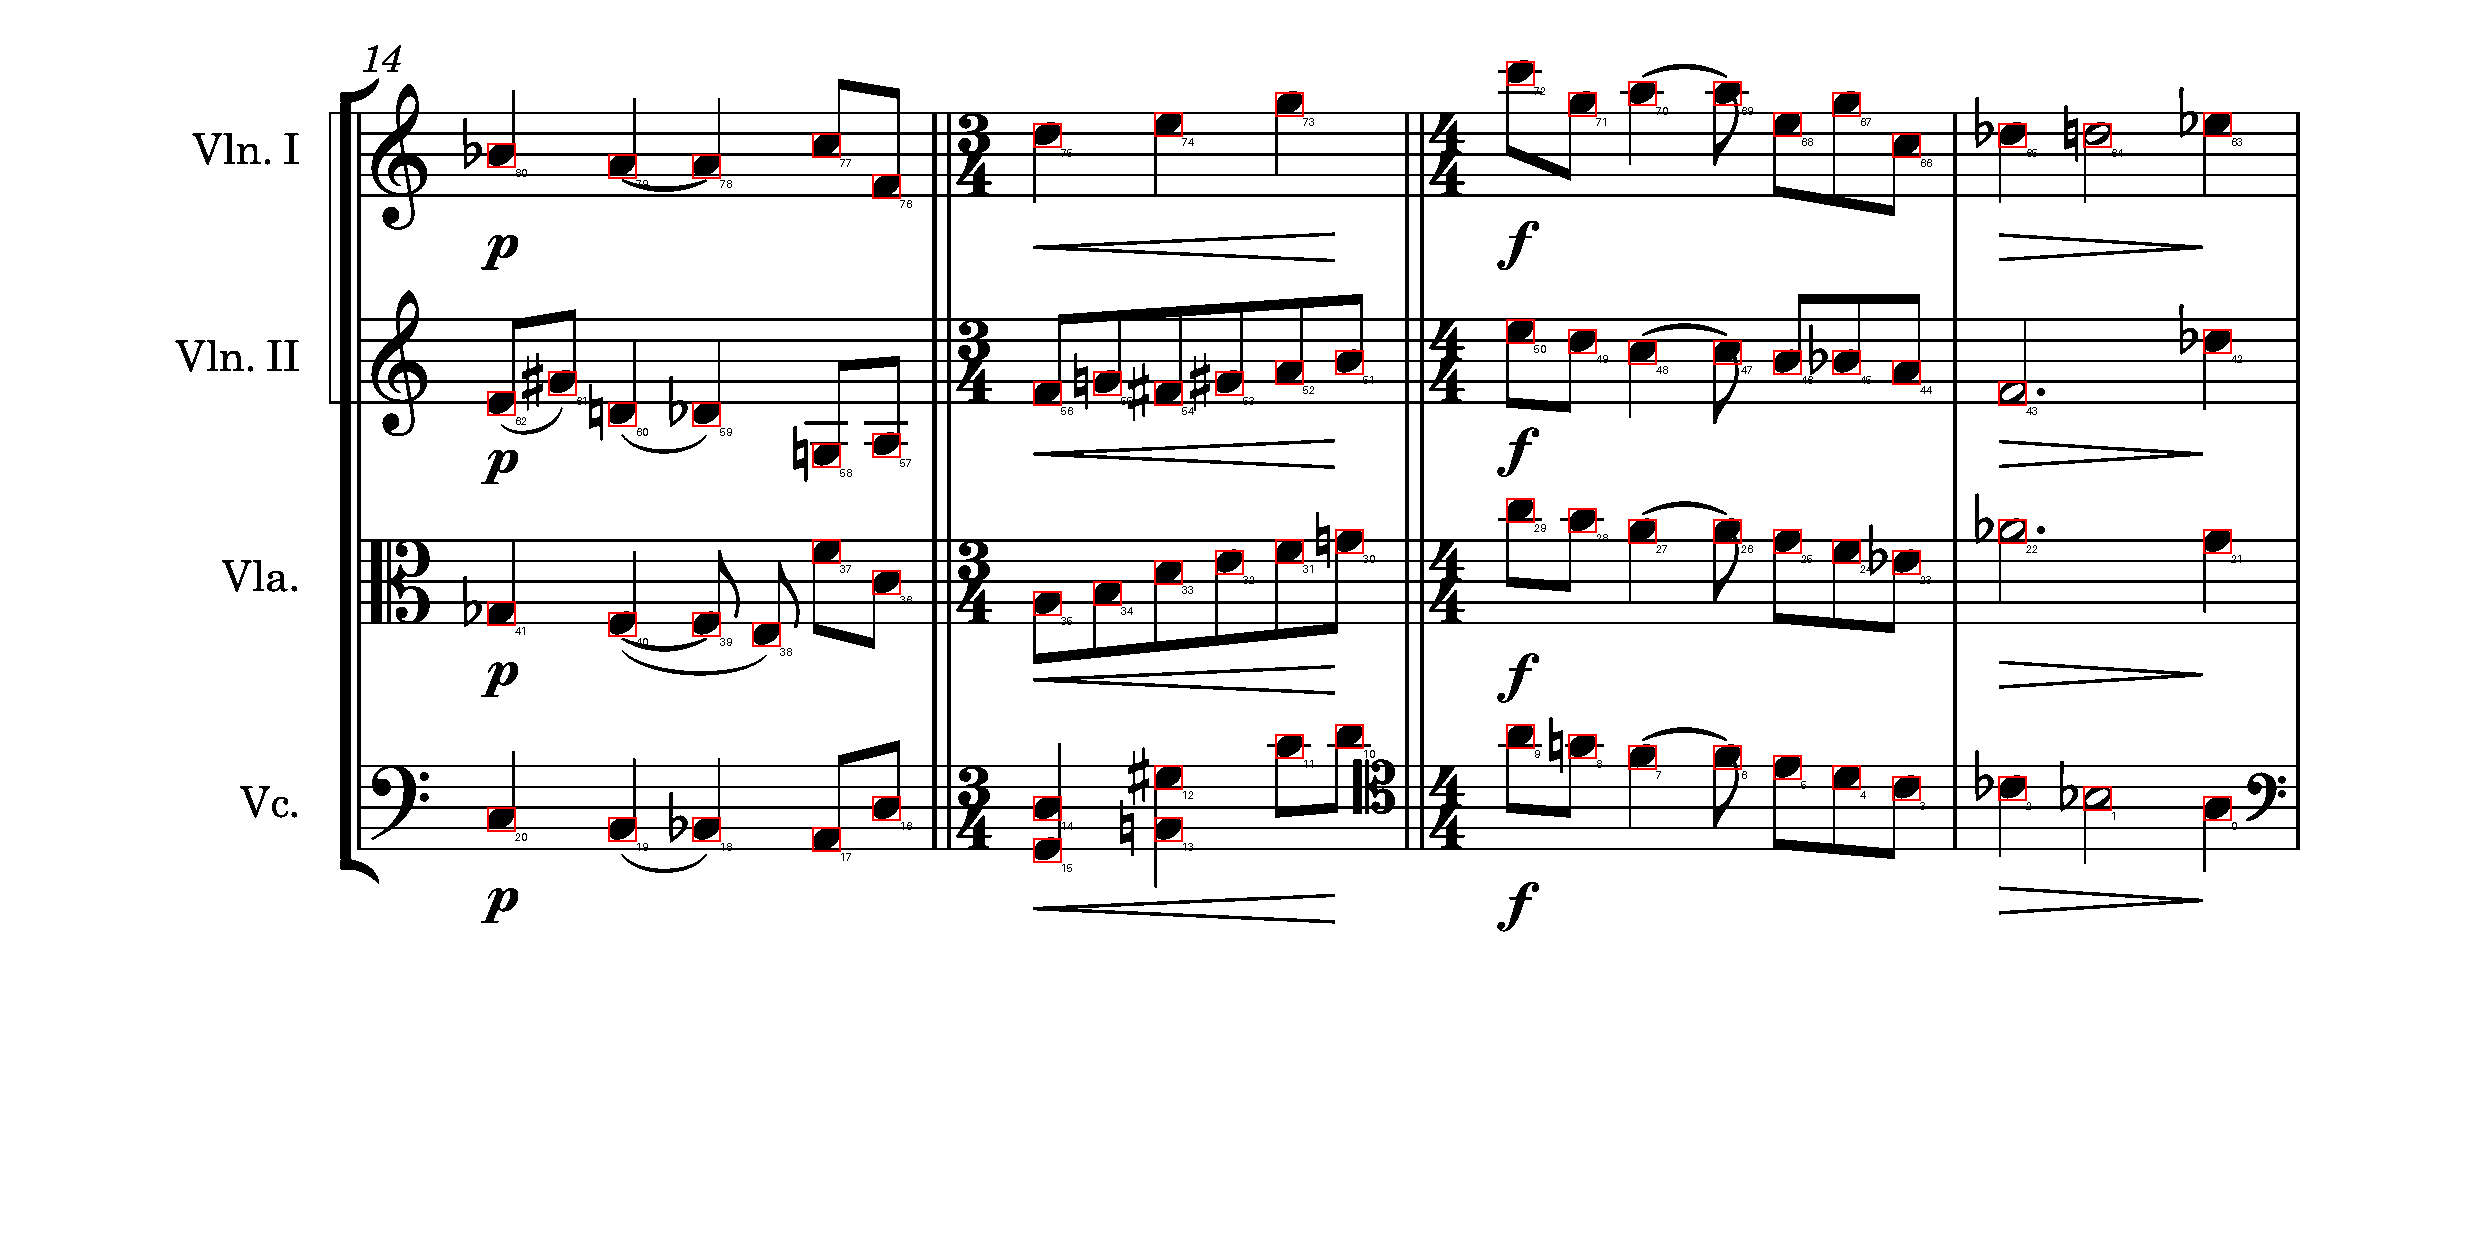

2475
1258


In [152]:
from PIL import Image, ImageDraw

for i in range(5):
    test_image, notes = CROPPED_NOTE_PAIRS[i]
    img = test_image.copy()  
    draw = ImageDraw.Draw(img)

    # Draw bounding boxes on the image
    counter = 0;
    for note in notes:
        draw.rectangle(note.create_box(), outline="red", width=2)
        draw.text(note.create_box()[1], str(counter), fill="black")
        counter += 1
    display(img)
    width, height = img.size
    print(width)
    print(height)
        
test_image, notes = CROPPED_NOTE_PAIRS[0]
img = test_image.copy()  
sample_cropped_img = test_image

# Extracting Note

In [153]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 

def remove_staff_lines(binary_img: np.ndarray) -> np.ndarray:
    """
    Detect and remove horizontal staff lines from the binary image input. 

    Output: 
        np.ndarray: a binary image with horizontal staff lines removed.
    """
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40,1))
    detected_stafflines = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, horizontal_kernel, iterations=1)
    return cv2.subtract(binary_img, detected_stafflines)

In [154]:
import cv2
import numpy as np

def selective_hole_fill(binary, min_hole_area, max_hole_area) -> np.ndarray:
    """
    Fill only fully enclosed holes whose area is between min_hole_area and max_hole_area.
    """
    # invert the binary image
    inv = cv2.bitwise_not(binary)
    
    # label connected components in inverted image
    num, labels, stats, centroids = cv2.connectedComponentsWithStats(inv, connectivity=8)
    
    h, w = binary.shape
    filled = binary.copy()

    # filling step
    for lbl in range(1, num): # iterated thru each component
        area = stats[lbl, cv2.CC_STAT_AREA] 
        # only fill holes in the desired size range
        if area < min_hole_area or area > max_hole_area:
            continue
        filled[labels == lbl] = 255

    return filled

In [155]:
WIDTH_FACTOR = 0.5
HEIGHT_FACTOR = 0.4
MIN_AREA = 100 # pixels
MAX_AREA = 600

MAX_HEIGHT_WIDTH_RATIO = 2.0 # h / w
MIN_WIDTH_HEIGHT_RATIO = 1 # w / h 
ELLIPSE_SIZE = 20.5
PAD = 4

def extract_noteheads(img, debug: bool) -> np.ndarray:
    # testing with 'cropped_img' variable
    gray_img = img.convert('L')
    gray_img = np.array(gray_img, dtype=np.uint8)

    # assign all pixel values higher than 127 to 255 and others to 0
    _, binary_img = cv2.threshold(gray_img, 127, 255, cv2.THRESH_BINARY_INV)
    
    if debug:
        plt.figure(figsize=(6,6))
        plt.imshow(binary_img, cmap='gray')
        plt.title("Binary Inverted")
        plt.axis('off')
        plt.show()
        
    # remove staff lines
    processed_img = remove_staff_lines(binary_img)

    # Performing morphological operations
    w_close = max(1, int(round(ELLIPSE_SIZE * 0.2)))
    h_close = max(1, int(round(ELLIPSE_SIZE * 0.4)))
    close_krn = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (w_close, h_close))
    closed = cv2.morphologyEx(processed_img, cv2.MORPH_CLOSE, close_krn)
    
    filled = selective_hole_fill(
        closed, 
        min_hole_area=150,
        max_hole_area=250,
        )
    
    if debug:
        plt.figure(figsize=(6,6))
        plt.imshow(closed, cmap='gray')
        plt.title("After Closed")
        plt.axis('off')
        plt.show()
           
    notehead_size = (
        int(round(ELLIPSE_SIZE * WIDTH_FACTOR)),
        int(round(ELLIPSE_SIZE * HEIGHT_FACTOR))
    )
    
    # erode away isolated pixels that are not note heads
    kernel_2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, notehead_size)
    opened = cv2.morphologyEx(filled, cv2.MORPH_OPEN, kernel_2)

    if debug:
        plt.figure(figsize=(6,6))
        plt.imshow(opened, cmap='gray')
        plt.title("After Opened")
        plt.axis('off')
        plt.show()
        
    w_close = max(1, int(round(ELLIPSE_SIZE * 0.1)))
    h_close = max(1, int(round(ELLIPSE_SIZE * 0.8)))
    close_krn = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (w_close, h_close))
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, close_krn)
    
    if debug:
        plt.figure(figsize=(6,6))
        plt.imshow(closed, cmap='gray')
        plt.title("After Second Closed")
        plt.axis('off')
        plt.show()
        
    # find contours
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if debug:
        canvas = cv2.cvtColor(closed, cv2.COLOR_GRAY2BGR)
        
        cv2.drawContours(canvas, contours, -1, (0,255,0), 1)
        
        plt.figure(figsize=(6,6))
        plt.imshow(canvas[...,::-1])
        plt.title(f'{len(contours)} contours found')
        plt.axis('off')
        plt.show()

    # filter out shapes that are not noteheads by checking how round the white area is
    notehead_mask = np.zeros_like(opened)
    for item in contours:
        area = cv2.contourArea(item)
        # print(area)
        if area < MIN_AREA or area > MAX_AREA:
            continue
        
        x, y, w, h = cv2.boundingRect(item)
        
        # Drop any blob that's too tall/thin:
        if h / float(w) > MAX_HEIGHT_WIDTH_RATIO:
            continue

        # Drop any blob that's too wide/flat:
        if w / float(h) < MIN_WIDTH_HEIGHT_RATIO:
            continue

        cv2.drawContours(notehead_mask, [item], -1, 255, -1)

    morphed = notehead_mask

    if debug:
        plt.figure(figsize=(6,6))
        plt.imshow(morphed, cmap='gray')
        plt.title("Morphed (staff lines out, noteheads closed)")
        plt.axis('off')
        plt.show()
        
    final_contours, _ = cv2.findContours(
        notehead_mask,
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )

    return morphed, final_contours

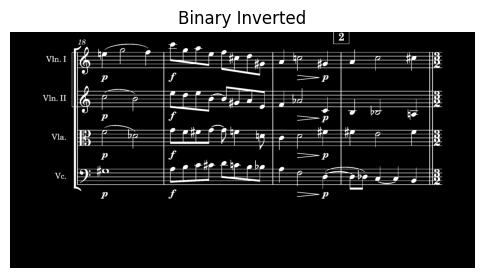

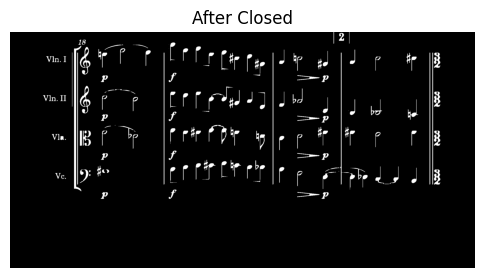

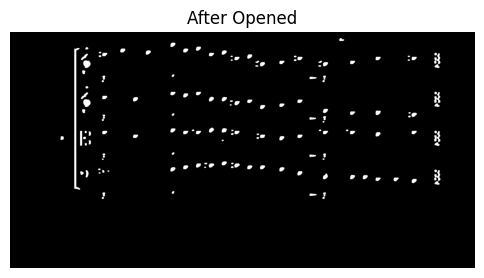

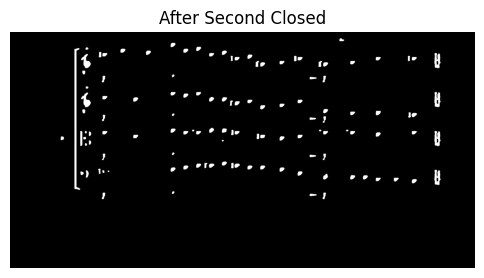

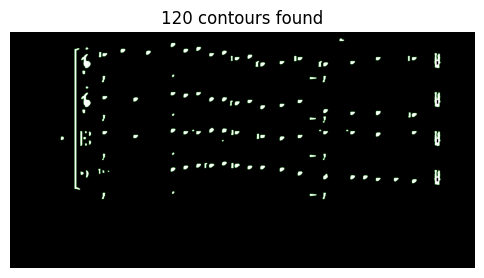

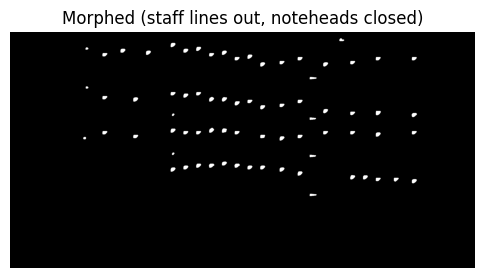

In [156]:
test_image, notes = CROPPED_NOTE_PAIRS[5]
morphed_img, contours = extract_noteheads(test_image, True)

In [157]:
def display_image(image, title="Image"):
    plt.figure(figsize=(10, 8))
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

In [158]:
def get_roi_coords(mask):
    """
    Compute padded bounding-box coordinates for a binary mask.
    Returns (x0, y0, x1, y1).
    """
    x, y, w, h = cv2.boundingRect(mask)
    # make sure we don't go out of bounds
    x0 = max(0, x - PAD) 
    y0 = max(0, y - PAD)
    x1 = min(mask.shape[1], x + w + PAD)
    y1 = min(mask.shape[0], y + h + PAD)
    return x0, y0, x1, y1

def split_horizontal_blob(mask, debug=False):
    """
    Split a single-blob mask horizontally through its vertical midpoint.
    Returns [top_half, bottom_half] or [mask] if one half is empty.
    """
    # Compute bounding box
    x, y, w, h = cv2.boundingRect(mask)
    mid_y = y + h // 2 # calculating the midway point

    # Empty masks
    top = np.zeros_like(mask)
    bottom = np.zeros_like(mask)

    # Slicing within bbox
    top[y:mid_y, x:x+w] = mask[y:mid_y, x:x+w]
    bottom[mid_y:y+h, x:x+w] = mask[mid_y:y+h, x:x+w]
    pieces = [top, bottom]

    # If one half is empty, return original. This means that either mask is completely all black
    if cv2.countNonZero(top) == 0 or cv2.countNonZero(bottom) == 0:
        return [mask]

    # Creating a kernel
    radius = 5
    ksize = 2 * radius + 1
    kern  = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ksize, ksize))

    # apply opening to each piece to erode straight edges, then dilate back
    # basically erosding away the straight edges and then dilating again to give it its shape back
    rounded = [cv2.morphologyEx(p, cv2.MORPH_OPEN, kern) for p in pieces]

    if debug:
        for i, m in enumerate(rounded):
            x0, y0, x1, y1 = get_roi_coords(mask)
            plt.figure(figsize=(3,3))
            plt.imshow(m[y0:y1, x0:x1], cmap='gray')
            plt.title(f'Rounded Piece #{i}')
            plt.axis('off')
        plt.show()

    return rounded

In [159]:
def split_blob(mask, debug=False):
    """
    Split a large binary mask into smaller ones using watershed,until each piece's nonzero area <= MAX_AREA.
    Returns a list of mask pieces.
    """
    # If this mask is already small enough, return it. Error checking bascially
    area = cv2.countNonZero(mask)
    if area <= MAX_AREA:
        if debug:
            x0, y0, x1, y1 = get_roi_coords(mask)
            plt.figure(figsize=(4,4))
            plt.imshow(mask[y0:y1, x0:x1], cmap='gray', vmin=0, vmax=255, interpolation='nearest')
            plt.title(f'Final Piece (area={area})')
            plt.axis('off')
        return [mask]

    # 1) Compute distance transform
    # Computes shortest distance from foreground pixel to the background pixel. Identifying the center regions of the object
    dist = cv2.distanceTransform(mask, cv2.DIST_L2, 5)
    if debug:
        x0, y0, x1, y1 = get_roi_coords(mask)

        plt.figure(figsize=(4,4))
        plt.imshow(dist[y0:y1, x0:x1], cmap='viridis', interpolation='nearest')
        plt.title('Distance Transform')
        plt.axis('off')

    # 2) Get sure foreground peaks (areas that are confidently park of the foreground, deep enough within the object)
    # Extracting deepest pixels from background boundary, 40% of blob distance
    thresh_val = 0.6 * dist.max()
    _, fg = cv2.threshold(dist, thresh_val, 255, cv2.THRESH_BINARY)
    fg = fg.astype(np.uint8) # converting to be used in OpenCV
    if debug:
        x0, y0, x1, y1 = get_roi_coords(mask)

        plt.figure(figsize=(4,4))
        plt.imshow(fg[y0:y1, x0:x1], cmap='gray', vmin=0, vmax=255, interpolation='nearest')
        plt.title('Sure Foreground Peaks')
        plt.axis('off')

    # 3) Create markers for watershed
    num_components, markers = cv2.connectedComponents(fg)
    if num_components < 2: # only one component in the foreground
        return [mask]
    markers = markers + 1 # 0 is reserved for the background
    unknown = cv2.subtract(mask, fg) # marking the unknown region
    markers[unknown == 255] = 0 # uncertain pixels
    
    if debug:
        x0, y0, x1, y1 = get_roi_coords(mask)

        plt.figure(figsize=(4,4))
        plt.imshow(markers[y0:y1, x0:x1], cmap='tab20', interpolation='nearest')
        plt.title('Watershed Markers')
        plt.axis('off')

    # 4) Apply watershed
    color = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR) # watershed needs a colored image
    cv2.watershed(color, markers) # running watershed, flooding from seed labels
    
    if debug:
        boundary_overlay = color.copy()
        boundary_overlay[markers == -1] = (0,0,255)
        x0, y0, x1, y1 = get_roi_coords(mask)

        plt.figure(figsize=(4,4))
        plt.imshow(boundary_overlay[y0:y1, x0:x1][..., ::-1], interpolation='nearest')
        plt.title('Watershed Boundaries ')
        plt.axis('off')

    # 5) Extract pieces
    pieces = []
    for lbl in range(2, num_components+1):
        piece = np.zeros_like(mask)
        piece[markers == lbl] = 255
        if cv2.countNonZero(piece) > 0:
            if debug:
                x0, y0, x1, y1 = get_roi_coords(piece)
                plt.figure(figsize=(4,4))
                plt.imshow(piece[y0:y1, x0:x1], cmap='gray', vmin=0, vmax=255, interpolation='nearest')
                plt.title(f'Piece {lbl-1}')
                plt.axis('off')
            pieces.append(piece)

    # If watershed didn't split, return original
    if not pieces:
        return [mask]
        
    aspect_thresh = 1.2 # height has to be 120% of width, if its greater, that means there are two notes on top of each other
    pieces = []
    
    for lbl in range(2, num_components+1):
        piece = np.zeros_like(mask)
        piece[markers == lbl] = 255
        if cv2.countNonZero(piece) > 0:
            # checking aspect ratio
            x,y,w,h = cv2.boundingRect(piece)
                
            if h > w * aspect_thresh or h * aspect_thresh > w:
                if True:
                    x0, y0, x1, y1 = get_roi_coords(piece)
                    plt.figure(figsize=(4,4))
                    plt.imshow(piece[y0:y1, x0:x1], cmap='gray', vmin=0, vmax=255, interpolation='nearest')
                    plt.title(f'Piece {lbl-1} height: {h}, width: {w}')
                    plt.axis('off')
                # split horizontally if its too tall or too wide
                sub = split_horizontal_blob(piece, True)
                pieces.extend(sub)
            else:
                if debug:
                    x0, y0, x1, y1 = get_roi_coords(piece)
                    plt.figure(figsize=(4,4))
                    plt.imshow(piece[y0:y1, x0:x1], cmap='gray', vmin=0, vmax=255, interpolation='nearest')
                    plt.title(f'Piece {lbl-1} (zoomed)'); plt.axis('off')
                pieces.append(piece)
    return pieces

In [160]:
import cv2
import numpy as np
id_num = 0
def refine_and_fit_ellipses(gray_img, notehead_mask, contours,
                            iou_thresh=0.75,
                            min_area=150,
                            min_ellipse_area=300,
                            min_minor_axis=10,
                            min_axis_ratio=0.5,
                            min_area_ratio=0.6,
                            MAX_AREA_ratio=1.3,
                            min_solidity=0.9,
                            debug=False,):
    """
    Returns two lists:
     - accepted: [( (cx,cy), (MA,ma), angle ), ... ]
     - rejected: [ ( (cx,cy), reason_string ), ... ]
    """
    H, W = gray_img.shape
    accepted, rejected = [], []
    global id_num
    for cnt in contours:
        # Computing the raw area
        rawA = cv2.contourArea(cnt)
        blob = np.zeros_like(notehead_mask)
        cv2.drawContours(blob, [cnt], -1, 255, -1)
        
        if debug:
            x0, y0, x1, y1 = get_roi_coords(blob)
            
            plt.figure(figsize=(4,4))
            plt.imshow(blob[y0:y1, x0:x1],
                       cmap='gray',
                       vmin=0, vmax=255,
                       interpolation='nearest')
            plt.title("Blob mask")
            plt.axis('off')

        # If raw area is bigger than the max area, split into multple blobs
        if rawA > MAX_AREA:
            submasks = split_blob(blob, False)
        else:
            submasks = [blob]

        for piece in submasks:
            # extracting pieces from the submask and adding PADding 
            x0, y0, x1, y1 = get_roi_coords(piece)

            roi_gray = gray_img[y0:y1, x0:x1]
            roi_mask = piece[y0:y1, x0:x1]
            
            if debug:
                plt.figure(figsize=(4,4))
                plt.imshow(roi_gray,
                           cmap='gray',
                           vmin=0, vmax=255,
                           interpolation='nearest')
                plt.title("ROI gray")
                plt.axis('off')
                
                plt.figure(figsize=(4,4))
                plt.imshow(roi_mask,
                           cmap='gray',
                           vmin=0, vmax=255,
                           interpolation='nearest')
                plt.title("ROI mask")
                plt.axis('off')
                
            # finding the local contours within the mask
            local_cnts, _ = cv2.findContours(
            roi_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
            )

            # Run 9 total tests
            for lc in local_cnts:
                area = cv2.contourArea(lc)
                cx_loc, cy_loc = cv2.boundingRect(lc)[:2]
                (cx_loc, cy_loc), (MA, ma), ang = cv2.fitEllipse(lc)
                note_metadata = ((cx_loc+x0, cy_loc+y0),(MA,ma),ang)
                
                # 1) raw-area floor
                if area < min_area or area > MAX_AREA:
                    rejected.append(note_metadata)
                    continue

                # 2) need at least 5 points to fit an ellipse
                if len(lc) < 5:
                    rejected.append(note_metadata)
                    continue

                # 4) ellipse-area floor
                ell_area = np.pi*(MA/2)*(ma/2)
                if ell_area < min_ellipse_area:
                    rejected.append(note_metadata)
                    continue

                # 5) minor-axis floor
                if min(MA, ma) < min_minor_axis:
                    rejected.append(note_metadata)
                    continue

                # 6) axis-ratio
                axis_r = min(MA,ma)/max(MA,ma)
                if axis_r < min_axis_ratio:
                    rejected.append(note_metadata)
                    continue

                # 7) area-ratio
                area_r = area/ell_area
                if not (min_area_ratio <= area_r <= MAX_AREA_ratio):
                    rejected.append(note_metadata)
                    continue

                # if we get here, it’s a keeper
                accepted.append((note_metadata, id_num))
                id_num+=1

    return accepted, rejected

In [161]:
from tqdm import tqdm
debug = False
ACCEPTED_NOTES = []
for test_img, notes in tqdm(CROPPED_NOTE_PAIRS, desc="Extracting noteheads", unit="pair"):    
    # 1) Make image gray & binary
    if not isinstance(test_img, np.ndarray):
        gray = np.array(test_img.convert('L'), dtype=np.uint8)
    else:
        gray = test_img.astype(np.uint8)
    
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    
    # 2) Extract noteheads
    morphed, contours = extract_noteheads(
        test_img,
        debug=False
    )
    
    # 3) Visualize the cleaned contours
    if debug:
        canvas = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)
        cv2.drawContours(canvas, contours, -1, (0,255,0), 2)
        plt.figure(figsize=(6,6))
        plt.imshow(canvas[..., ::-1])
        plt.title(f"Cleaned Image {i}: {len(contours)} contours")
        plt.axis('off')
        plt.show()
        
    # 4) Now call the new fitter
    accepted, rejected = refine_and_fit_ellipses(
        gray_img = gray,
        notehead_mask = morphed,
        contours = contours,
        min_area = MIN_AREA,
        debug = False
    )
    ACCEPTED_NOTES.append((gray, accepted))
    if debug:
        print(f"Accepted: {len(accepted)} ellipses")
        print(f"Rejected: {len(rejected)} blobs")
        
        # 5) Overlay the kept ellipses on your original
        canvas2 = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
        for (cx,cy), (MA,ma), ang in accepted:
            cv2.ellipse(
                canvas2,
                (int(round(cx)), int(round(cy))),
                (int(round(MA/2)), int(round(ma/2))),
                angle=ang,
                startAngle=0,
                endAngle=360,
                color=(0,0,255),
                thickness=2
            )
        
        plt.figure(figsize=(8,8), dpi=200)
        plt.imshow(canvas2[..., ::-1])
        plt.title(f"Accepted Ellipses: {len(accepted)}")
        plt.axis('off')
        plt.show()
         
        canvas2 = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
        for (cx,cy), (MA,ma), ang in rejected:
            cv2.ellipse(
                canvas2,
                (int(round(cx)), int(round(cy))),
                (int(round(MA/2)), int(round(ma/2))),
                angle=ang,
                startAngle=0,
                endAngle=360,
                color=(0,0,255),
                thickness=2
            )
            
        plt.figure(figsize=(8,8), dpi=200)
        plt.imshow(canvas2[..., ::-1])
        plt.title(f"Rejected Ellipses: {len(rejected)}")
        plt.axis('off')
        plt.show()
    

Extracting noteheads: 100%|██████████| 90/90 [00:11<00:00,  7.72pair/s]


In [162]:
debug = False
TARGET_SIZE = (39, 23)

def crop_pad_notes(gray_img, accepted, debug = False):
    H, W = gray_img.shape[:2]
    bboxes = []
    for ((cx, cy), (MA, ma), _), id_num in accepted:
        # center X, center Y
        # Major Axis - width
        # Minor axis - height
        w = int(round(MA))
        h = int(round(ma))
        x0 = max(0, int(round(cx - w/2)))
        y0 = max(0, int(round(cy - h/2)))
        x1 = min(W, int(round(cx + w/2)))
        y1 = min(H, int(round(cy + h/2)))
        bboxes.append(((x0, y0, x1, y1), id_num))

    # finding universal size
    IMAGE_WIDTH, IMAGE_HEIGHT = 0,0
    for (x0,y0,x1,y1), _ in bboxes:
        IMAGE_WIDTH = max(x1 - x0, IMAGE_WIDTH)
        IMAGE_HEIGHT = max(y1 - y0, IMAGE_HEIGHT)

    if debug:
        print(f"IMAGE_WIDTH: {IMAGE_WIDTH} IMAGE_HEIGHT: {IMAGE_HEIGHT}")
    
    padded_imgs = []
    for (x0,y0,x1,y1), id_num in bboxes:
        cropped = gray_img[y0:y1, x0:x1]
        # print(id_num)
        padded_imgs.append((cropped, (x0,y0,x1,y1), id_num))
    return padded_imgs

IMAGE_DATA = []
for img, accepted in tqdm(ACCEPTED_NOTES, desc="Cropping noteheads", unit="pair"):
    img_arr = np.array(img)
    cropped_images = crop_pad_notes(img_arr, accepted)
    for idx, (crop_img, bbox, id_num) in enumerate(cropped_images):
        if debug:
            plt.figure(figsize=(3,3))
            plt.imshow(crop_img, cmap='gray', vmin=0, vmax=255)
            plt.title(f"Cropped Note {idx+1}")
            plt.axis('off')
            plt.show()
        IMAGE_DATA.append((crop_img, id_num))

TRAINING_IMAGES = [(cv2.resize(crop, (TARGET_SIZE[1], TARGET_SIZE[0])), id_num) for crop, id_num in IMAGE_DATA]

Cropping noteheads: 100%|██████████| 90/90 [00:00<00:00, 1188.06pair/s]


In [163]:
len(TRAINING_IMAGES)

3368

# Calculating Pitch

In [173]:
def calculate_pitch(cy, staff_center, unit_size):
    pitch_step = round(-(cy - staff_center) / (unit_size / 2))
    
    pitch_names = {
    -20: "C", -19: "D", -18: "E", -17: "F", -16: "G",
    -15: "A", -14: "B", -13: "C", -12: "D", -11: "E",
    -10: "F",  -9: "G",  -8: "A",  -7: "B",  -6: "C",
     -5: "D",  -4: "E",  -3: "F",  -2: "G",  -1: "A",
      0: "B",   1: "C",   2: "D",   3: "E",   4: "F",
      5: "G",   6: "A",   7: "B",   8: "C",   9: "D",
     10: "E",  11: "F",  12: "G",  13: "A",  14: "B",
     15: "C",  16: "D",  17: "E",  18: "F",  19: "G",
     20: "A"
    }

    pitch = pitch_names.get(pitch_step, "Unknown")
    return pitch, pitch_step

In [165]:
def calculate_pitch_multi(y, staffs):
    """
    Pick the correct staff for a note at vertical position y,
    then compute its pitch & step using that staff's center & unit_size.
    """
    # 1) find any staff whose bounds contain y
    for st in staffs:
        if st.upper_bound <= y <= st.lower_bound:
            return calculate_pitch(y, st.center, st.unit_size)

    # 2) if none matched perfectly, fall back to the *closest* staff center
    closest = min(staffs, key=lambda s: abs(s.center - y))
    return calculate_pitch(y, closest.center, closest.unit_size)

# Multiclass Classification

## Loading Dataset

In [166]:
import pandas as pd

df = pd.read_pickle('/kaggle/input/multiclass-noteheads/df_trunc.pkl')

In [167]:
mapping = {
    "noteheadBlack": 1,
    "noteheadHalf":  0,
    "noteheadWhole": 0
}

df['label_binary'] = df['label'].map(mapping)
print(df['label_binary'].value_counts())

label_binary
0    274
1    150
Name: count, dtype: int64


## Building CNN 

This binary classifier will identify if notes are hollow or not

In [168]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization)
from tensorflow.keras.callbacks import EarlyStopping

IMAGE_SHAPE = (39, 23, 1)

binary_model = Sequential([
    # First Convolutional Block
    Conv2D(32, (3,3), activation='relu', input_shape=IMAGE_SHAPE),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    
    # Second Convolutional Block
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    
    # Classifier
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),

    # Single–unit sigmoid output for binary classification
    Dense(1, activation='sigmoid')
])

binary_model.summary()

binary_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_23 (Conv2D)                   │ (None, 37, 21, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 37, 21, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 18, 10, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 16, 8, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 16, 8, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 8, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 281,601 (1.07 MB)

 Trainable params: 281,409 (1.07 MB)

 Non-trainable params: 192 (768.00 B)

In [169]:
from sklearn.model_selection import train_test_split

X = df["image"].tolist()
X = np.stack(X) # Stacking arrays into a tensor

print("Data shape", X.shape)

y = df["label_binary"].values

X_train, X_test, y_train, y_test = train_test_split(
    X,y,
    test_size = 0.2, # 80/20 split
    stratify=y, # Need equal parts of each class in each
    random_state=42
)
print("Train class distribution:", np.bincount(y_train))
print("Test  class distributino:", np.bincount(y_test))

Data shape (424, 23, 39)
Train class distribution: [219 120]
Test  class distributino: [55 30]


In [177]:
result = binary_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=25,
    batch_size=32
)

Epoch 1/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 4.3926e-07 - val_accuracy: 0.6235 - val_loss: 0.7530
Epoch 2/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 2.5416e-08 - val_accuracy: 0.6353 - val_loss: 0.7206
Epoch 3/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 6.3901e-08 - val_accuracy: 0.6353 - val_loss: 0.6781
Epoch 4/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 4.2867e-09 - val_accuracy: 0.6353 - val_loss: 0.6264
Epoch 5/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 8.5285e-08 - val_accuracy: 0.6353 - val_loss: 0.5674
Epoch 6/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 2.9969e-07 - val_accuracy: 0.6471 - val_loss: 0.5041
Epoch 7/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 3.9136e-08 - val_accuracy: 0.7412 - val_loss: 0.4333
Epoch 8/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 1.326

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


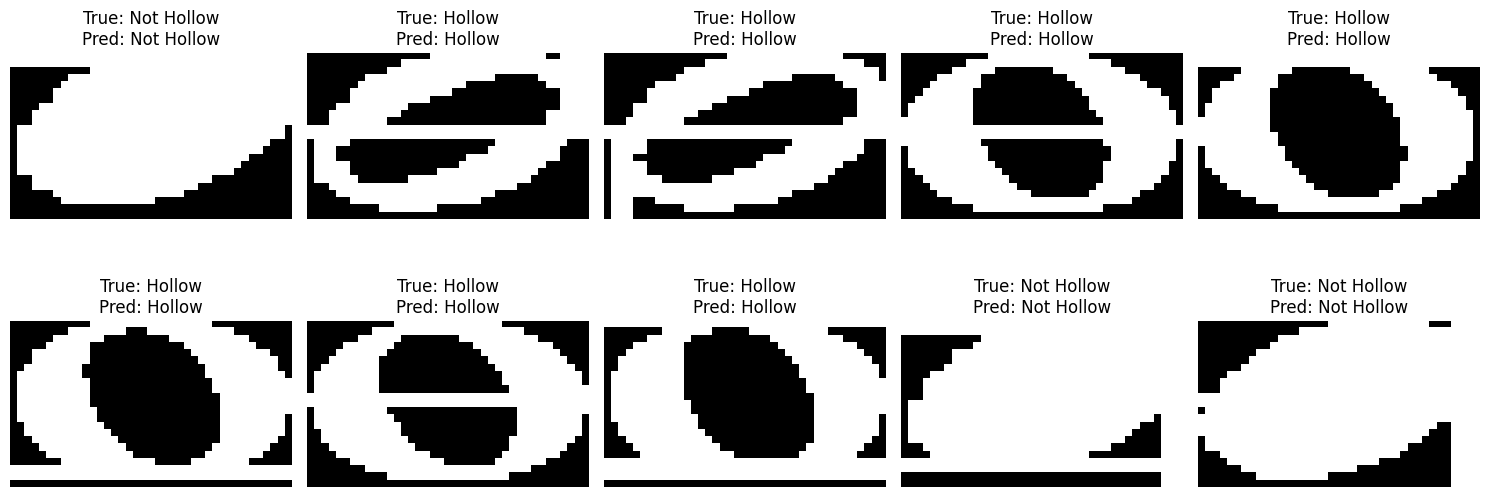

In [179]:
probs = binary_model.predict(X_test).ravel() 
predicted = (probs > 0.5).astype(int) 

reverse_mapping = {1:"Not Hollow", 0:"Hollow"}

n = 10
indexes = np.random.choice(len(X_test), size=n, replace=False)

fig, axes = plt.subplots(2, 5, figsize=(15,6))
axes = axes.flatten()

for ax, i in zip(axes, indexes):
    img  = X_test[i].squeeze()
    true_lbl = y_test[i]
    pred_lbl = predicted[i]  

    ax.imshow(img, cmap='gray')
    ax.set_title(
        f"True: {reverse_mapping[true_lbl]}\n"
        f"Pred: {reverse_mapping[pred_lbl]}"
    )
    ax.axis('off')

plt.tight_layout()
plt.show()


In [180]:
binary_model.save("binary_model.h5")

### Predicting on images from filtering 

In [ ]:
import cv2

def binarize_and_invert(img, thresh=127):
    _, binary = cv2.threshold(img, thresh, 255, cv2.THRESH_BINARY)
    inverted = 255 - binary
    return inverted

# Apply to your DataFrame
df_images['binarized'] = df_images['image'].apply(binarize_and_invert)

# Quick sanity check on shapes and dtypes
print(df_images[['id', 'binarized']].head())

In [251]:
X = df_images["binarized"].tolist()
X = np.stack(X) 
X = X[..., np.newaxis].astype("float32") / 255.0

probs = binary_model.predict(X)
preds = (probs > 0.5).astype(int)

preds_flat = preds.ravel() 
id_to_pred = dict(zip(df_images["id"], preds_flat))
id_to_pred = {int(k): int(v) for k, v in id_to_pred.items()}

print(id_to_pred)

df_images['pred'] = df_images['id'].map(id_to_pred)
df_zero = df_images[df_images['pred'] == 0].copy()

106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 0, 33: 0, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 0, 70: 1, 71: 1, 72: 1, 73: 0, 74: 1, 75: 1, 76: 1, 77: 1, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 1, 84: 1, 85: 1, 86: 1, 87: 1, 88: 0, 89: 1, 90: 1, 91: 1, 92: 1, 93: 1, 94: 1, 95: 1, 96: 1, 97: 1, 98: 1, 99: 1, 100: 1, 101: 1, 102: 1, 103: 1, 104: 1, 105: 1, 106: 0, 107: 1, 108: 1, 109: 1, 110: 1, 111: 1, 112: 1, 113: 1, 114: 1, 115: 1, 116: 1, 117: 1, 118: 1, 119: 1, 120: 0, 121: 1, 122: 1, 123: 1, 124: 1, 125: 1, 126: 1, 127: 1, 128: 1, 129: 1, 130: 1, 131: 1, 132: 1, 133:

106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


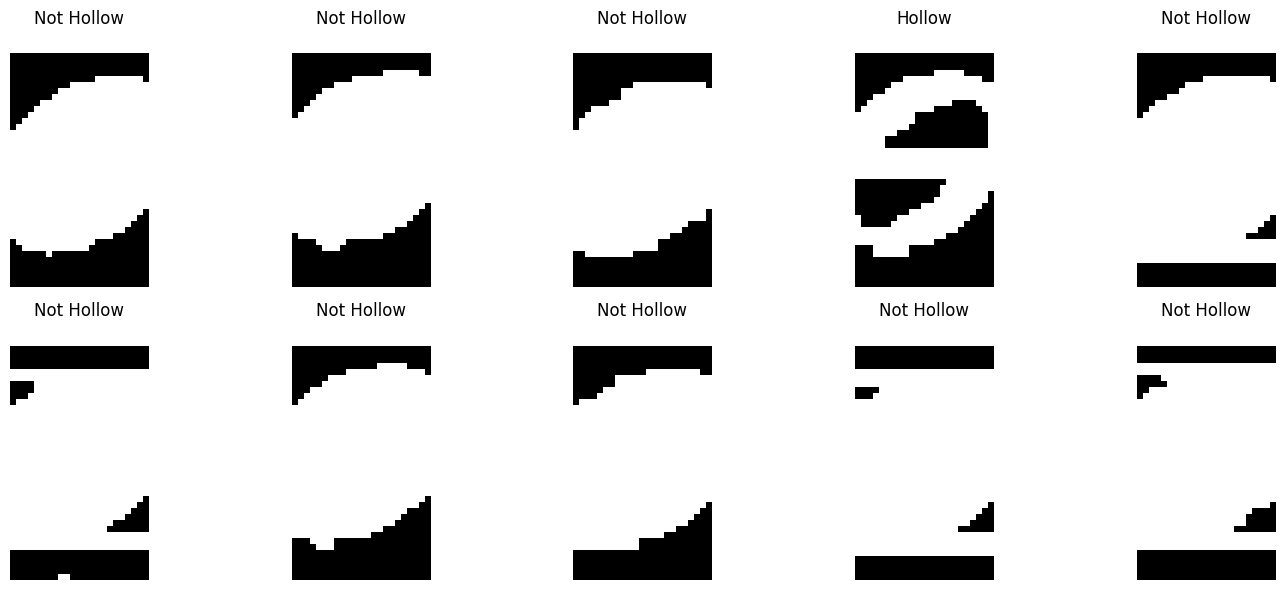

In [230]:
import numpy as np
import matplotlib.pyplot as plt

X = np.stack(df_images["binarized"].tolist(), axis=0)
X = X[..., np.newaxis].astype("float32") / 255.0

probs = binary_model.predict(X).ravel()
preds = (probs > 0.5).astype(int)

reverse_mapping = {0:"Hollow", 1:"Not Hollow"}

n = 10
indexes = np.random.choice(len(X), size=n, replace=False)

fig, axes = plt.subplots(2, 5, figsize=(15,6))
for ax, i in zip(axes.flatten(), indexes):
    img = X[i].squeeze()
    pred_lbl = preds[i]
    label_txt = reverse_mapping[pred_lbl]

    ax.imshow(img, cmap='gray')
    ax.set_title(f"{label_txt}\n")
    ax.axis('off')

plt.tight_layout()
plt.show()


### Whole Note vs Half Note CNN

In [234]:
import pickle

with open('/kaggle/input/multiclass-noteheads/df_full', 'rb') as f:
    df_whole_half = pickle.load(f)

print(df_whole_half.head)

<bound method NDFrame.head of                                                   image          label  \
0     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...  noteheadWhole   
1     [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...  noteheadWhole   
2     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...  noteheadWhole   
3     [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...  noteheadWhole   
4     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...  noteheadWhole   
...                                                 ...            ...   
999   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   noteheadHalf   
1000  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   noteheadHalf   
1001  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   noteheadHalf   
1002  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   noteheadHalf   
1003  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   noteheadHalf   

      label_encoded  
0                 2  
1                 2  
2              

In [235]:
whole_half_df = df_whole_half[df_whole_half['label'].isin(['noteheadWhole','noteheadHalf'])].copy()

whole_half_df['y'] = whole_half_df['label'].map({'noteheadHalf': 0, 'noteheadWhole':1})

height, width = 23, 39
X = np.stack(whole_half_df['image'].values)
X = X.reshape(-1, height, width, 1).astype('float32')
y = whole_half_df['y'].values

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(whole_half_df['y'].value_counts())

y
1    350
0    350
Name: count, dtype: int64


In [236]:
import numpy as np
import matplotlib.pyplot as plt

def show_equal_by_class(X, y, label_map):

    np.random.seed(42)
    
    classes = np.unique(y)
    # collect indices for each class
    idcs = []
    for cls in classes:
        cls_idx = np.where(y == cls)[0]
        chosen = np.random.choice(cls_idx, 5, replace=False)
        idcs.append(chosen)
    
    # flatten and prepare grid
    idcs = np.concatenate(idcs)
    rows = len(classes)
    cols = n_per_class
    fig, axes = plt.subplots(rows, cols, figsize=(2*cols, 2*rows))
    
    for row, cls in enumerate(classes):
        for col in range(n_per_class):
            ax = axes[row, col] if rows>1 else axes[col]
            i = idcs[row*n_per_class + col]
            img = X[i].squeeze()
            ax.imshow(img, cmap='gray')
            ax.set_title(label_map[cls], fontsize=8)
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

In [237]:
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, GlobalAveragePooling2D, Dense)
from tensorflow.keras.models import Model 
from tensorflow.keras import regularizers

IMAGE_SHAPE = (height, width, 1)
WEIGHT_DECAY = 1e-4
reg = regularizers.l2(WEIGHT_DECAY)

hollow_model = Sequential([
    Conv2D(32, (3,3), padding='same', activation='relu', kernel_regularizer=reg, input_shape=IMAGE_SHAPE), 
    BatchNormalization(),
    MaxPooling2D(2),
    Dropout(0.25), 

    Conv2D(64, (3,3), padding='same', activation='relu', kernel_regularizer=reg),
    BatchNormalization(),
    MaxPooling2D(2),
    Dropout(0.35),

    Conv2D(128, (3,3), padding='same', activation='relu',
           kernel_regularizer=reg),
    BatchNormalization(),
    MaxPooling2D(2),
    Dropout(0.45),

    GlobalAveragePooling2D(),
    Dense(64, activation='relu', kernel_regularizer=reg),
    BatchNormalization(),
    Dropout(0.5),

    Dense(1, activation='sigmoid', kernel_regularizer=reg)
])

hollow_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

hollow_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)                   │ (None, 23, 39, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_34               │ (None, 23, 39, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 11, 19, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 11, 19, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 11, 19, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_35               │ (None, 11, 19, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 5, 9, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 5, 9, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 5, 9, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_36               │ (None, 5, 9, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 2, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 2, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_37               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 102,145 (399.00 KB)

 Trainable params: 101,569 (396.75 KB)

 Non-trainable params: 576 (2.25 KB)

Epoch 1/25
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1:37 6s/step - accuracy: 0.5938 - loss: 0.9454

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - accuracy: 0.7403 - loss: 0.6069 - val_accuracy: 0.5000 - val_loss: 0.7152
Epoch 2/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9470 - loss: 0.1728 - val_accuracy: 0.5000 - val_loss: 0.8351
Epoch 3/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9546 - loss: 0.1198 - val_accuracy: 0.5000 - val_loss: 1.0405
Epoch 4/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9863 - loss: 0.0725 - val_accuracy: 0.5000 - val_loss: 1.2804
Epoch 5/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9940 - loss: 0.0522 - val_accuracy: 0.5000 - val_loss: 1.4716
Epoch 6/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9994 - loss: 0.0443 - val_accuracy: 0.5000 - val_loss: 1.6550
Epoch 7/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9920 - loss: 0.0499 - val_accuracy: 0.5000 - val_loss: 1.8507
Epoch 8/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9967 - loss: 0.0385 - val_accuracy: 0.5000 - val_loss: 1.

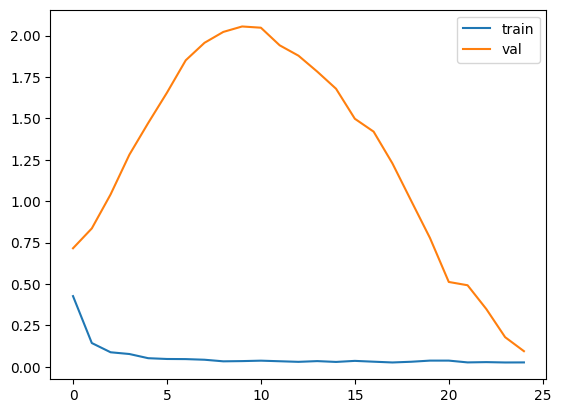

In [238]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    fill_mode='nearest'
)
datagen.fit(X_train)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history = hollow_model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=25,
)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend(); plt.show()

In [239]:
hollow_model.save("hollow_model.h5")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


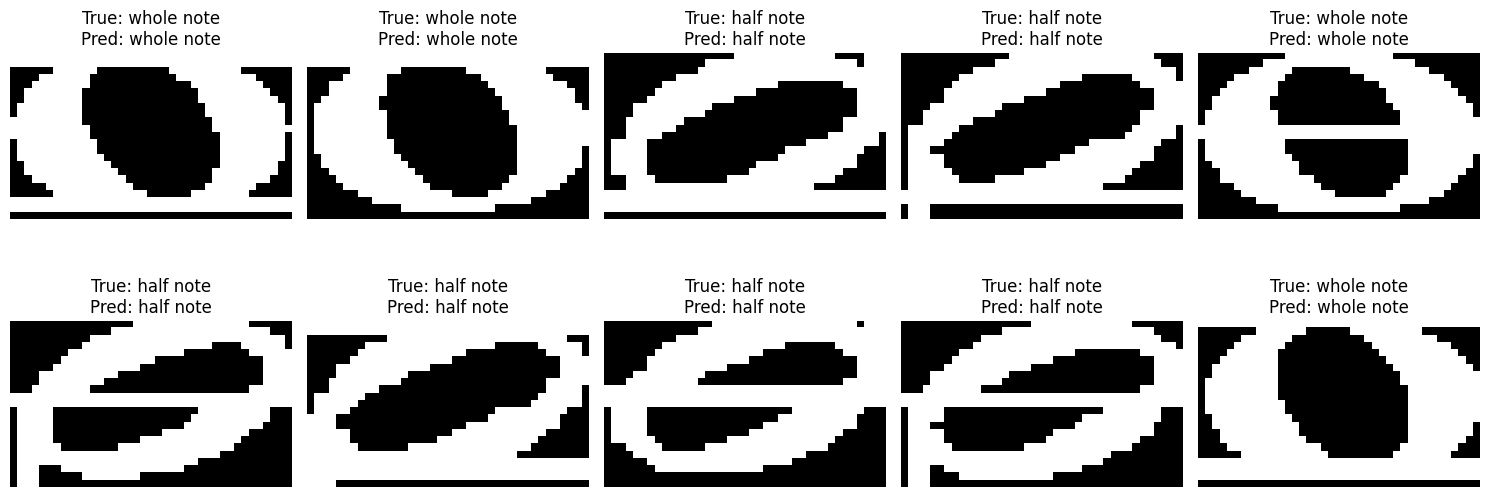

In [256]:
probs = hollow_model.predict(X_val).ravel()
predicted = (probs > 0.5).astype(int)

reverse_mapping = {0: "half note", 1: "whole note"}

n=10
indexes = np.random.choice(len(X_val), size=n, replace=False)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for ax, idx in zip(axes, indexes):
    img = X_val[idx].squeeze()    # (39,23) image
    true_lbl = y_val[idx]         # 0 or 1
    pred_lbl = predicted[idx]      # 0 or 1

    ax.imshow(img, cmap='gray')
    ax.set_title(
        f"True: {reverse_mapping[true_lbl]}\n"
        f"Pred: {reverse_mapping[pred_lbl]}"
    )
    ax.axis('off')

plt.tight_layout()
plt.show()

In [258]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val, predicted)
print("             Pred half   Pred whole")
print(f"True half    {cm[0,0]:4d}         {cm[0,1]:4d}")
print(f"True whole   {cm[1,0]:4d}         {cm[1,1]:4d}")

             Pred half   Pred whole
True half      70            0
True whole      0           70


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


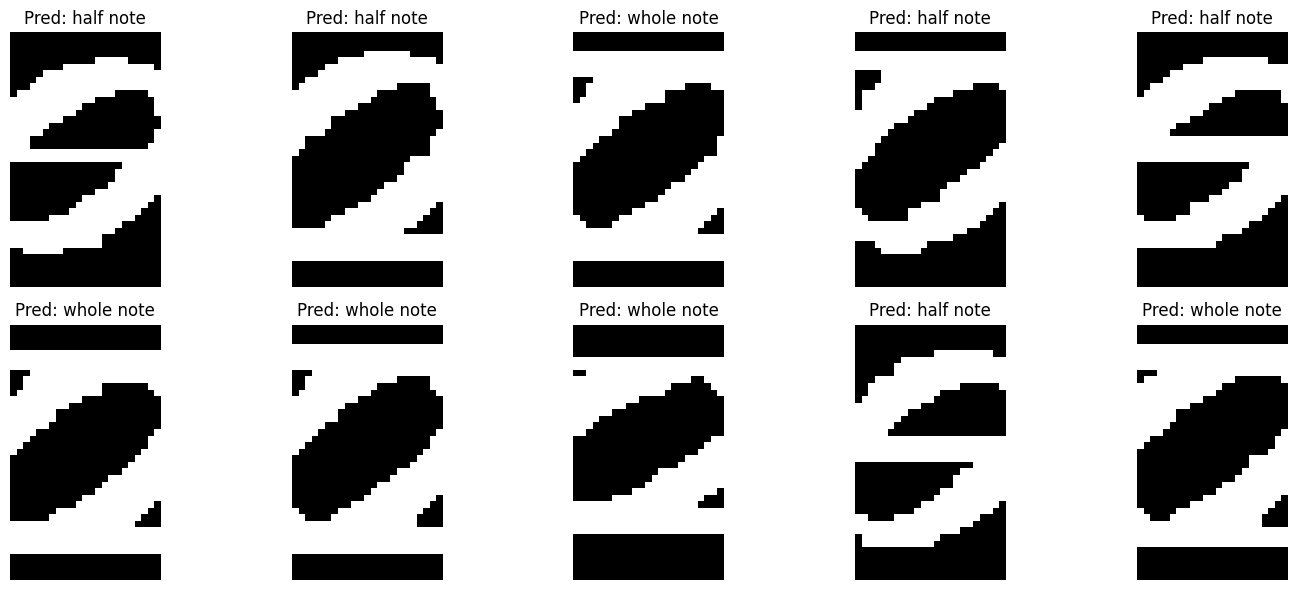

In [265]:
import numpy as np
import matplotlib.pyplot as plt

X = np.stack(df_zero["binarized"].tolist(), axis=0)
X = X[..., np.newaxis].astype("float32") / 255.0

probs = hollow_model.predict(X).ravel()
predicted = (probs > 0.5).astype(int)

reverse_mapping = {0: "half note", 1: "whole note"}

n=10
indexes = np.random.choice(len(X), size=n, replace=False)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for ax, idx in zip(axes, indexes):
    img = X[idx].squeeze()    # (39,23) image
    pred_lbl = predicted[idx] # 0 or 1
    
    ax.imshow(img, cmap='gray')
    ax.set_title(
        f"Pred: {reverse_mapping[pred_lbl]}"
    )
    ax.axis('off')

plt.tight_layout()
plt.show()

# Final Image

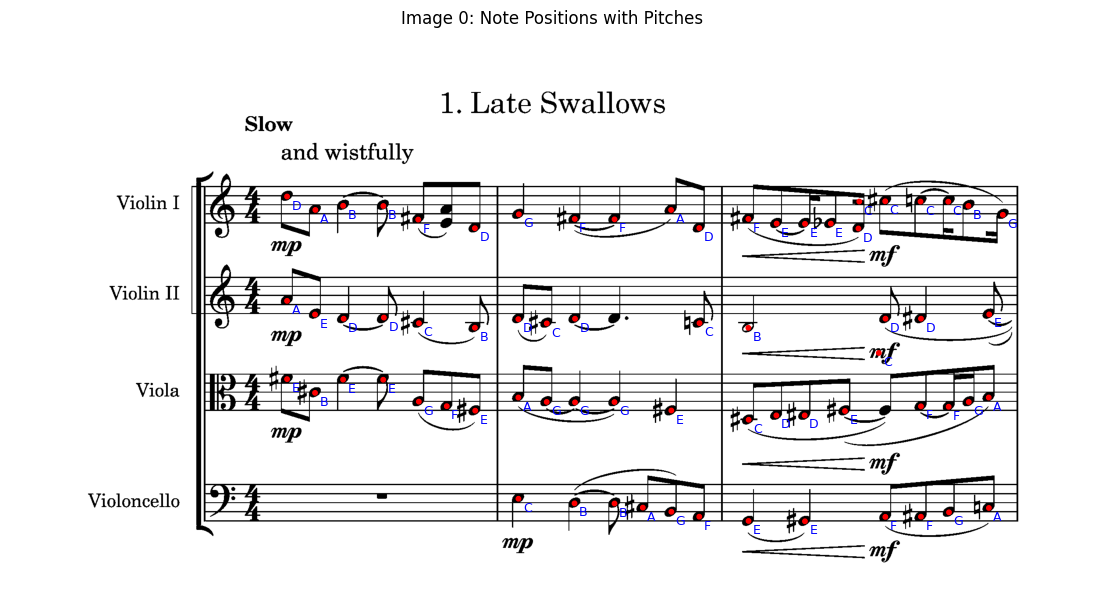

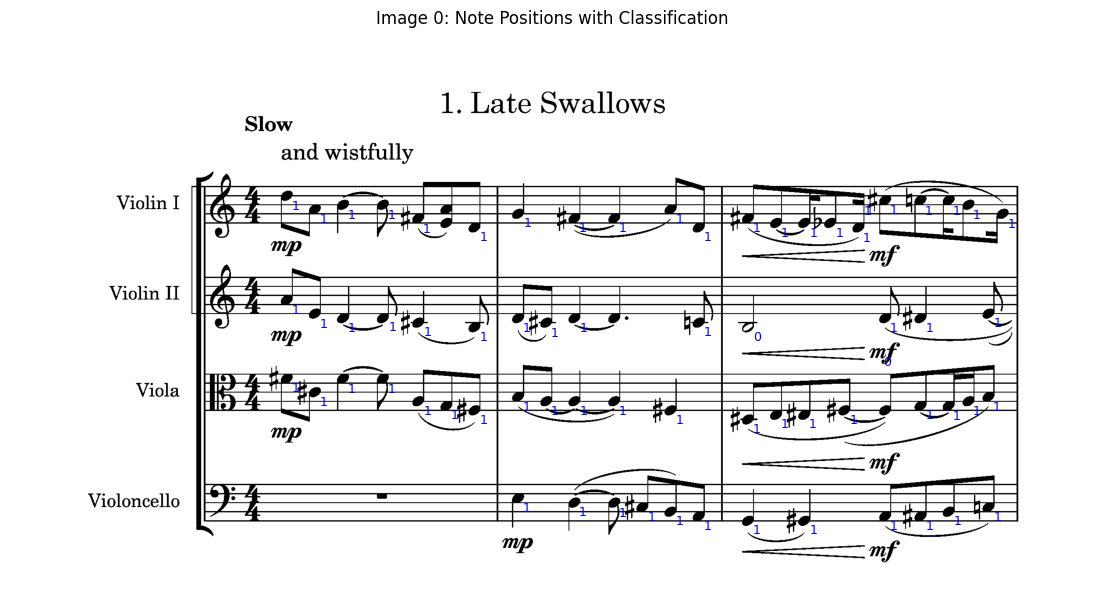

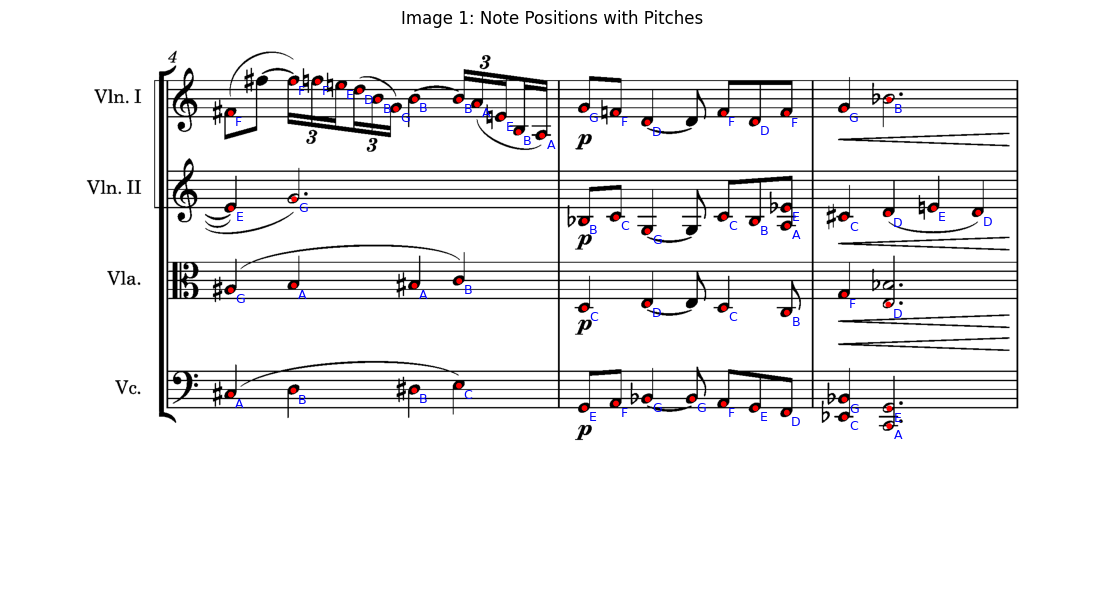

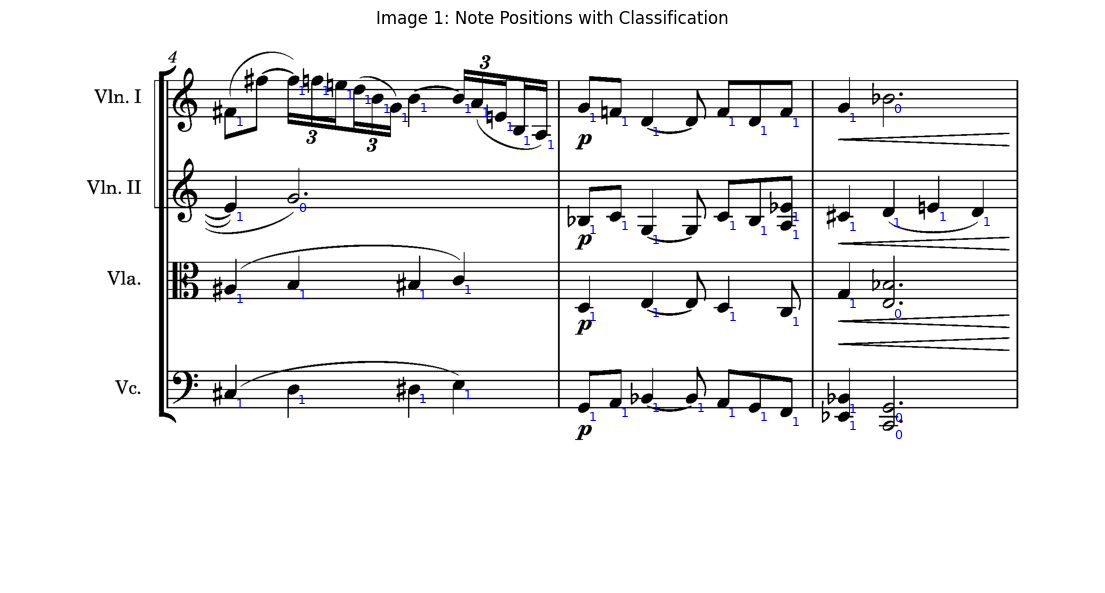

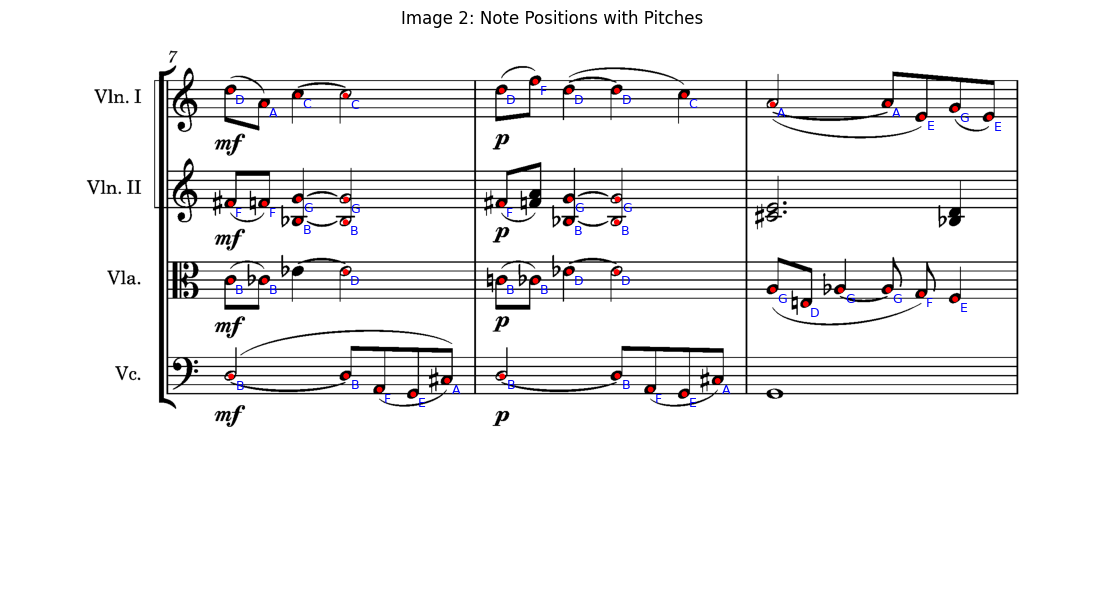

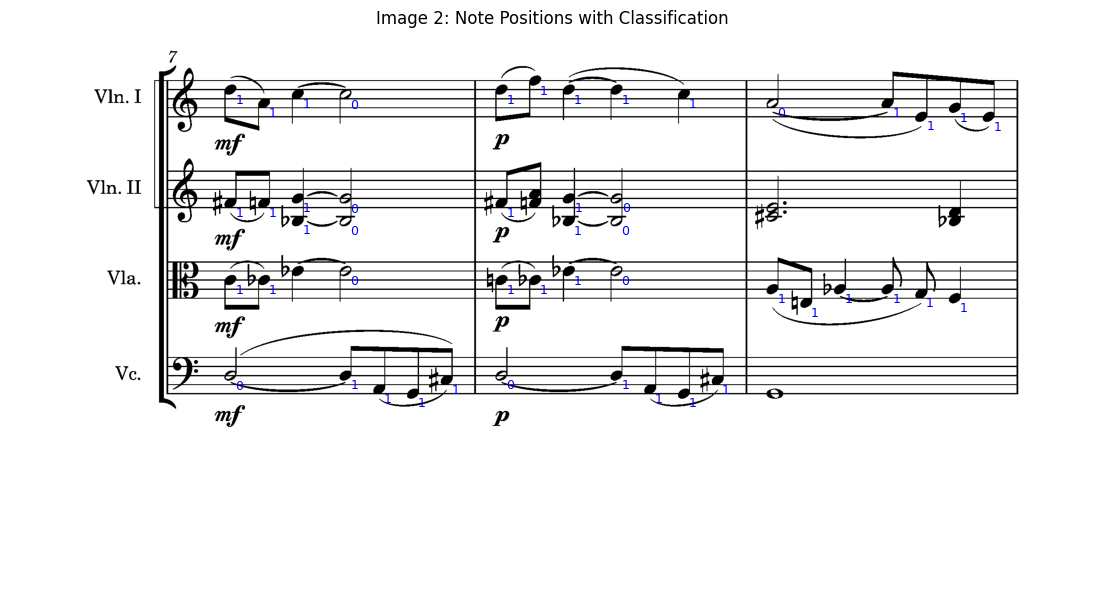

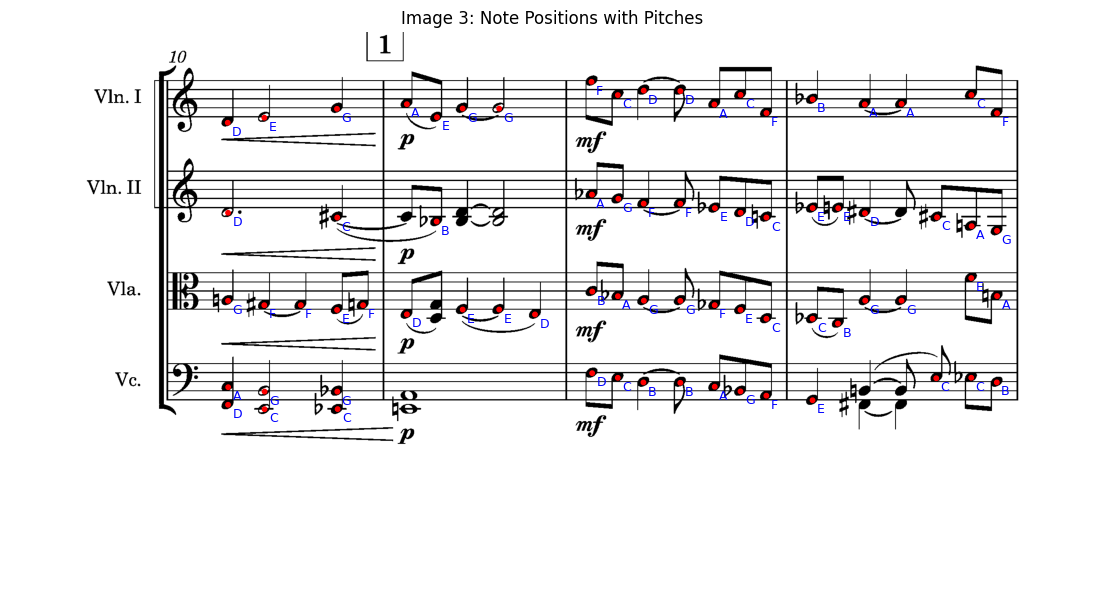

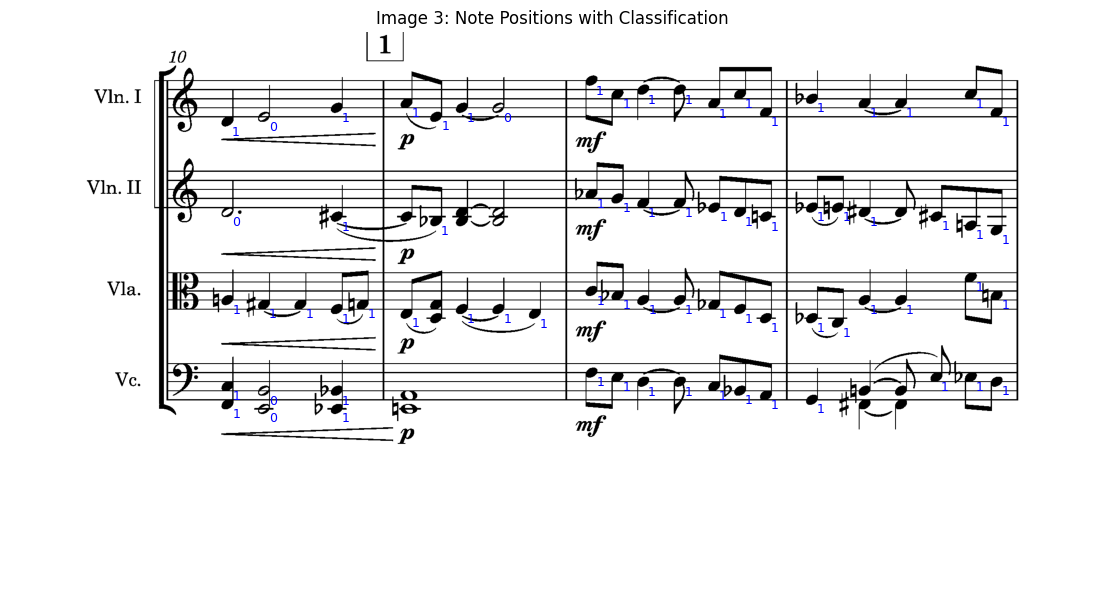

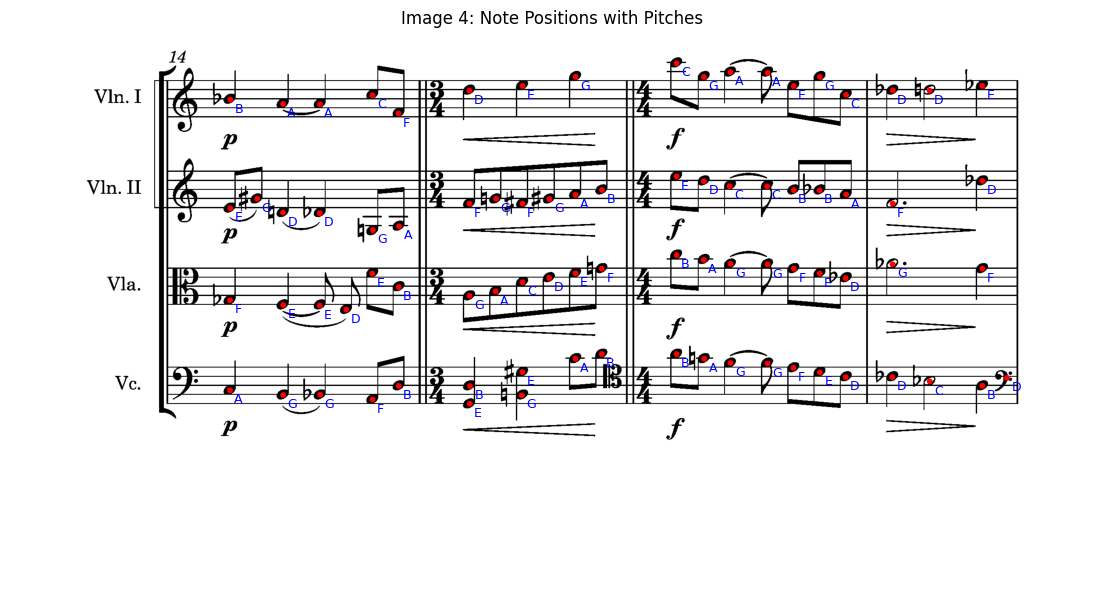

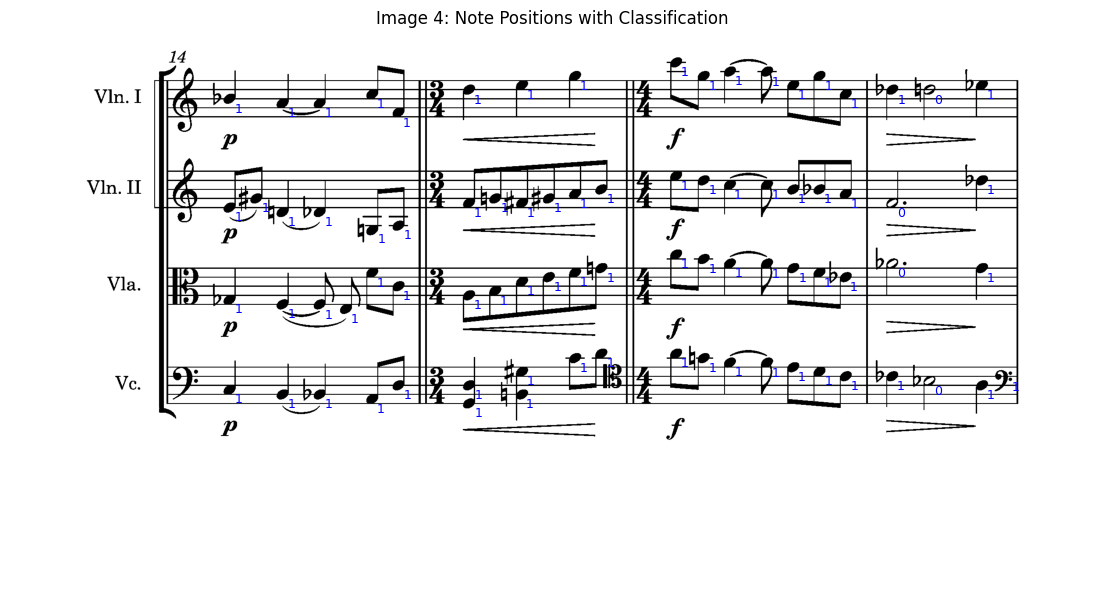

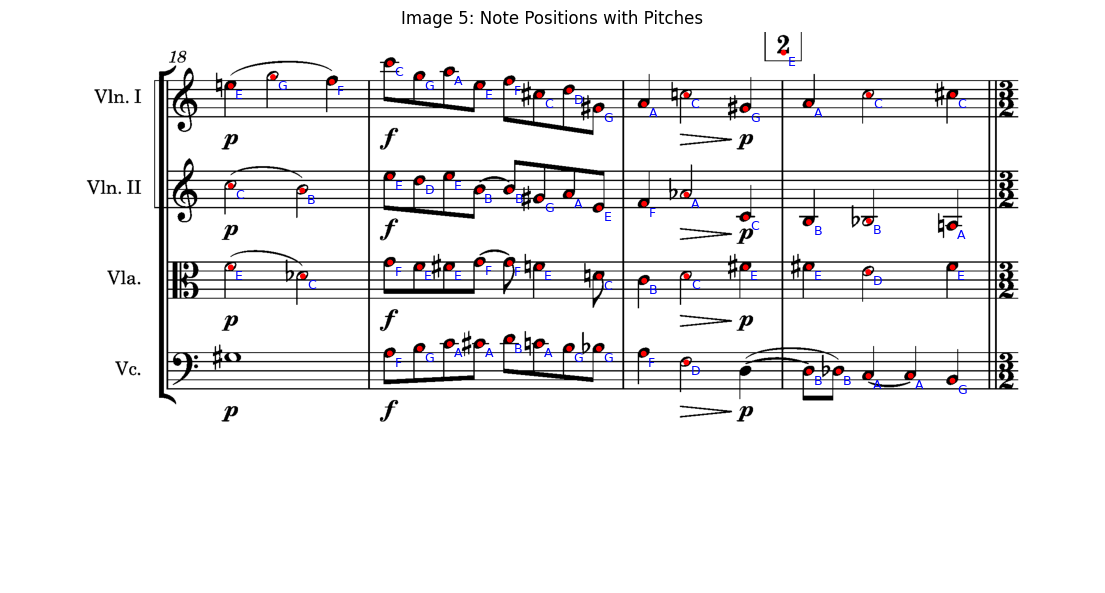

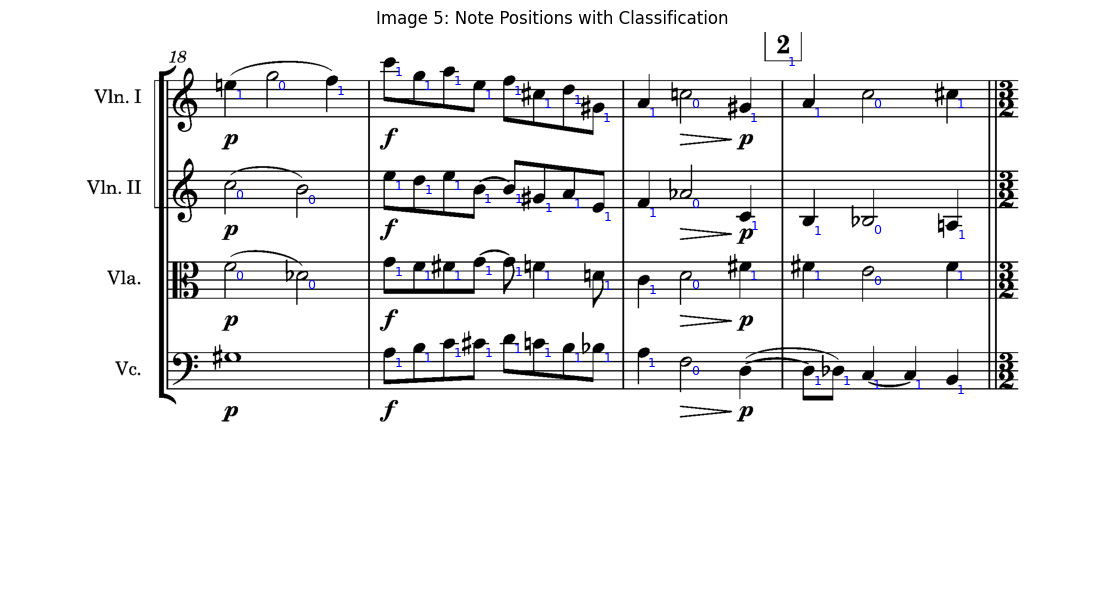

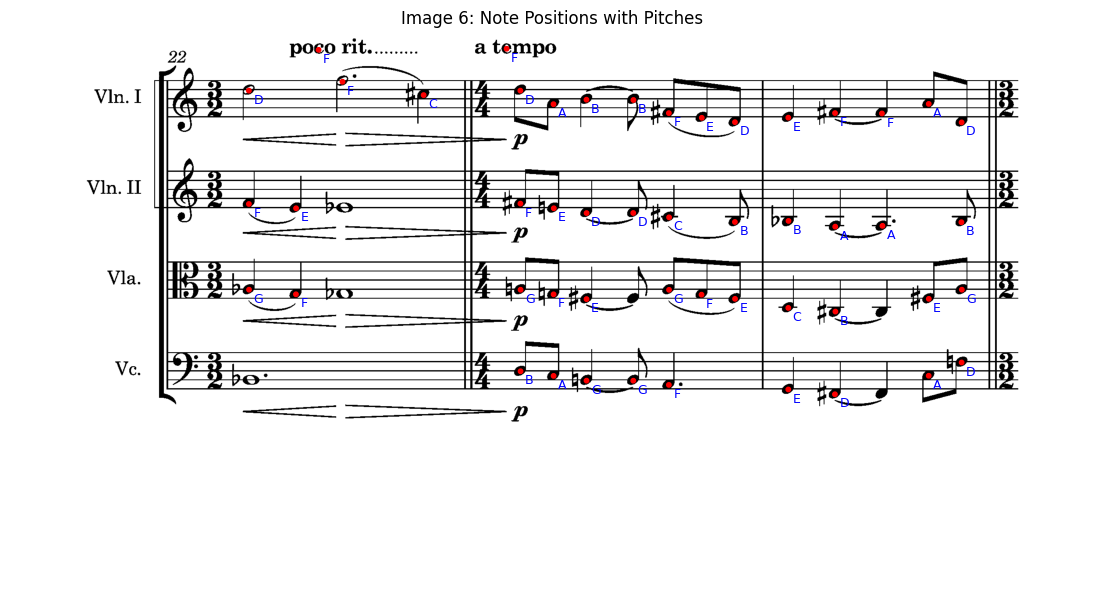

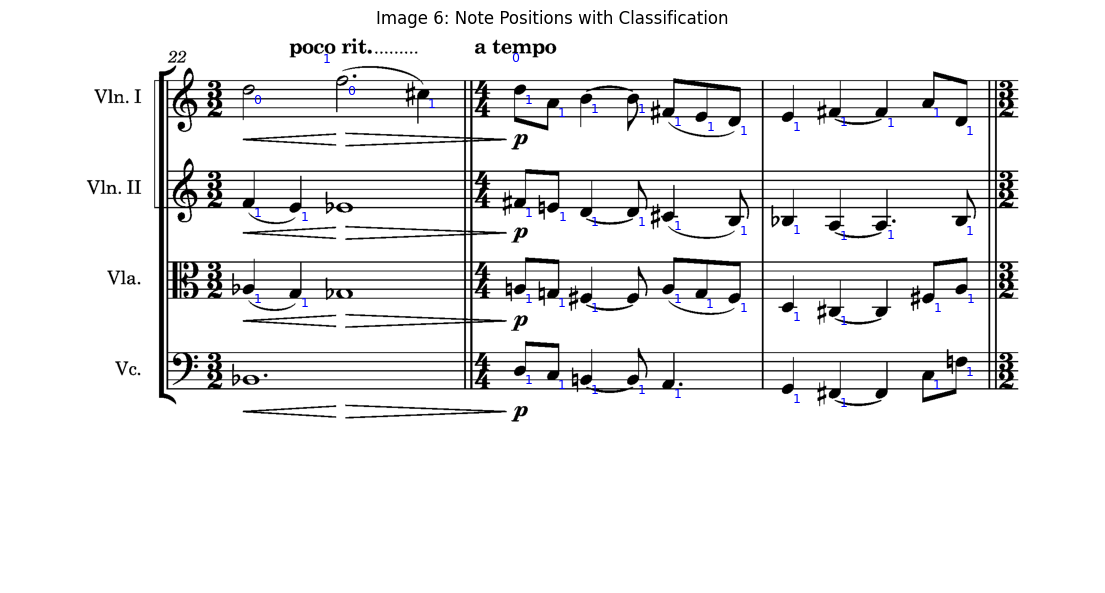

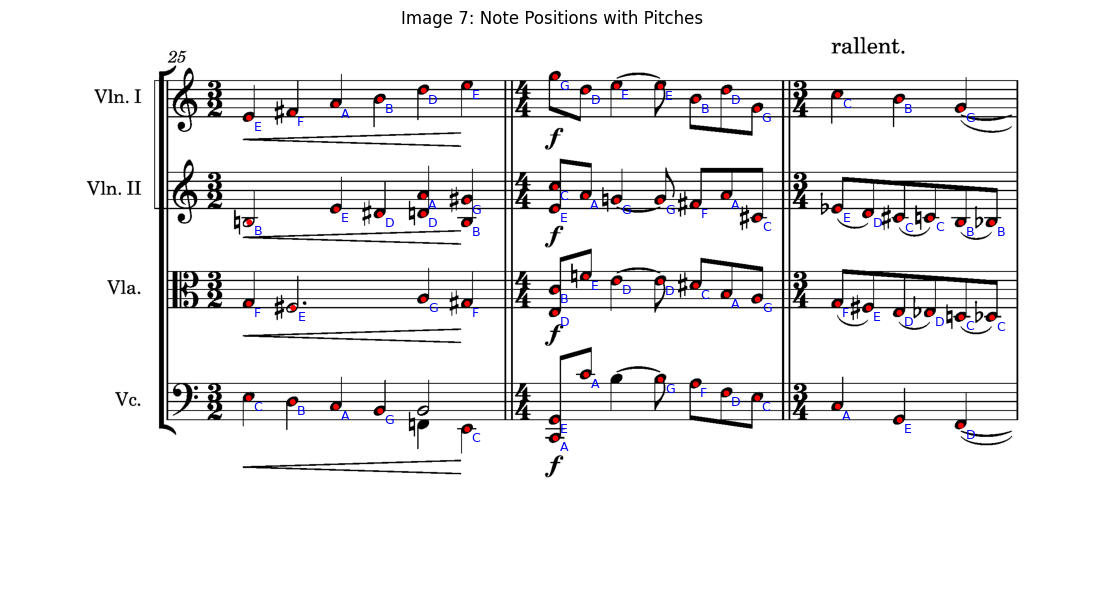

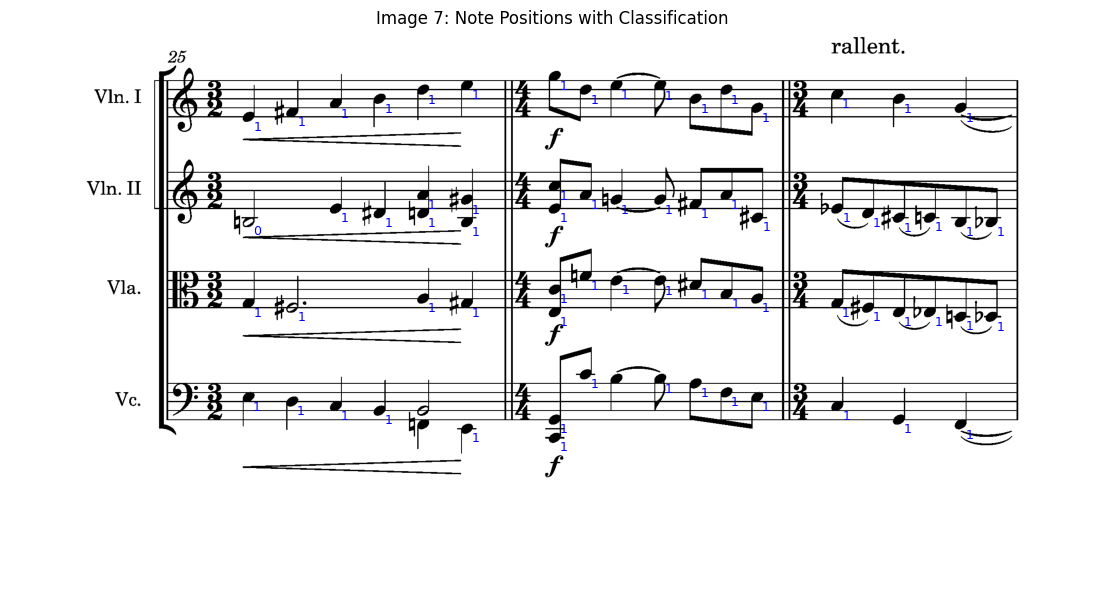

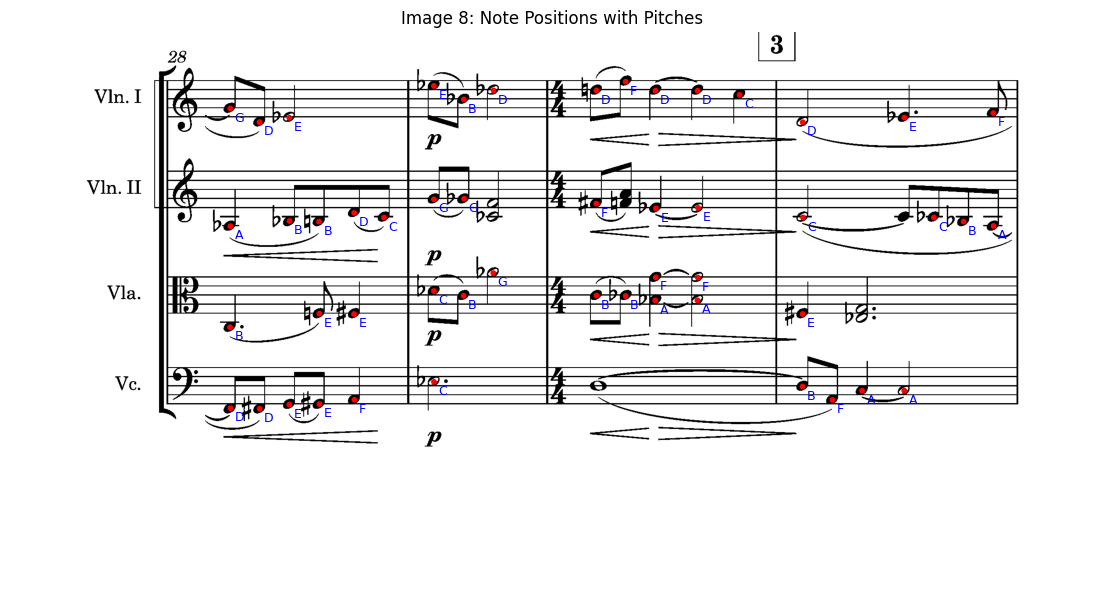

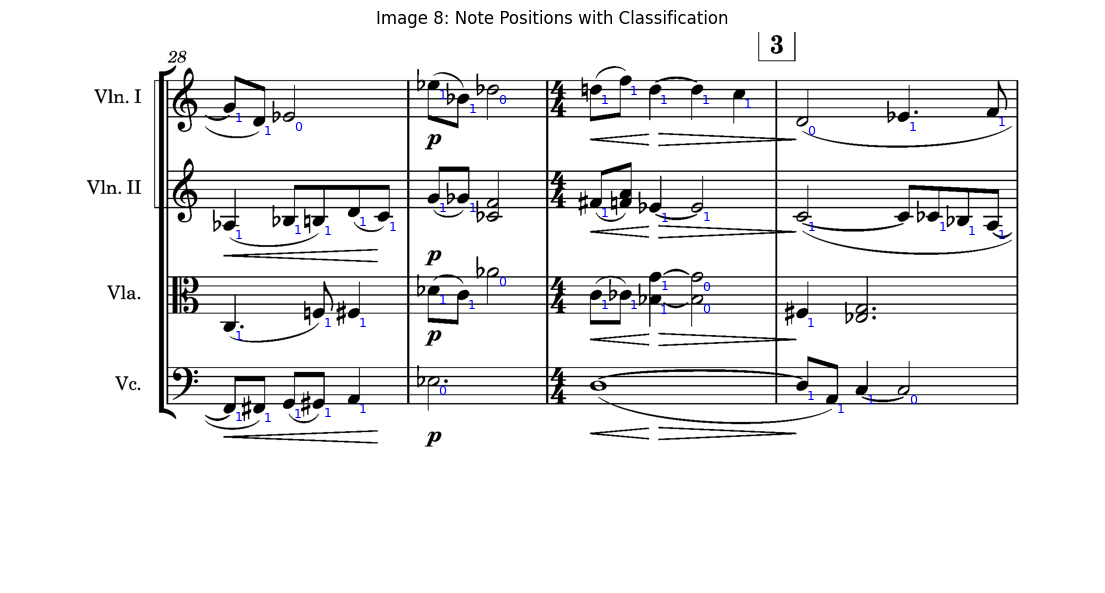

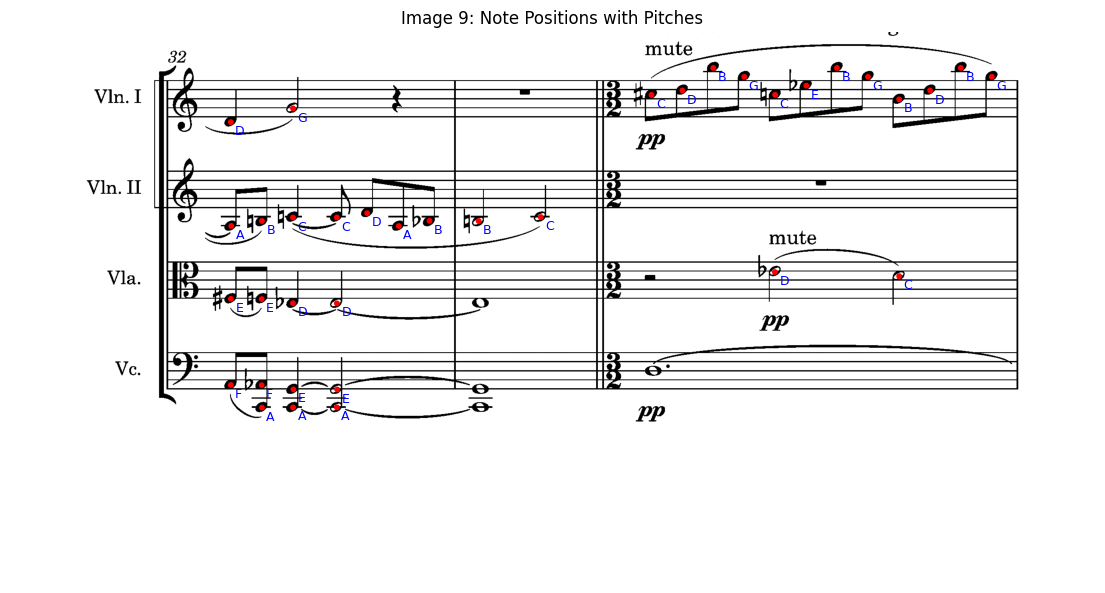

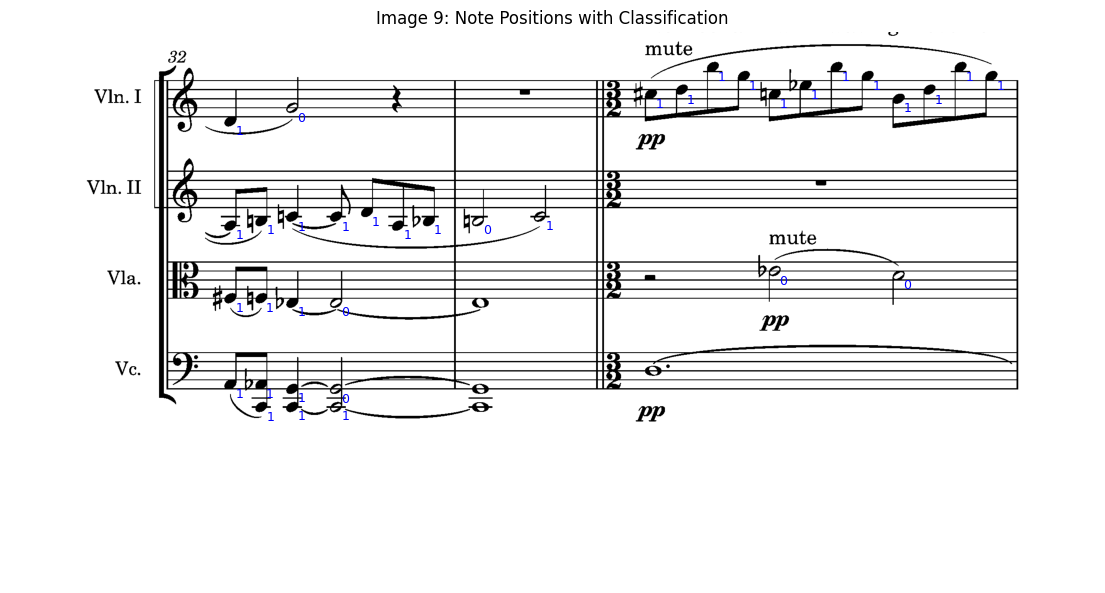

In [266]:
import matplotlib.pyplot as plt
from PIL import Image

for idx in range(10):
    img, notes = ACCEPTED_NOTES[idx]
    img_pil = Image.fromarray(img)
    staff_objects = extract_staffs_from_image(img_pil)

    fig, ax = plt.subplots(figsize=(14, 8))
    ax.imshow(img_pil, cmap='gray')
    ax.set_title(f"Image {idx}: Note Positions with Pitches")
    for (((cx, cy), (MA, ma), ang), num_id) in notes:
        pred_lbl = reverse_mapping[id_to_pred[num_id]]
        pitch, step = calculate_pitch_multi(cy, staff_objects)
        
        circ = plt.Circle((cx, cy), radius=5, color='red', fill=True)
        ax.add_patch(circ)
        ax.text(cx + 10, cy + 20, f"{pitch}", color='blue', fontsize=9, verticalalignment='center')
        
    ax.axis('off')
    plt.show()

    fig, ax = plt.subplots(figsize=(14, 8))
    ax.imshow(img_pil, cmap='gray')
    ax.set_title(f"Image {idx}: Note Positions with Classification")
    for (((cx, cy), (MA, ma), ang), num_id) in notes:
        ax.text(cx + 10, cy + 20, f"{id_to_pred[num_id]}", color='blue', fontsize=9, verticalalignment='center')
    ax.axis('off')
    plt.show()


# Appendix

Reference Github: https://github.com/BreezeWhite/oemer

Importing sample image from the [DoReMi](https://github.com/steinbergmedia/DoReMi/?tab=readme-ov-file#OMR-metadata) dataset.